# Forecasting fire probability and sizes with SMLFire1.0

Author: Jatan Buch (v1, 230724) || (v2, 230818) || (v3, 230824)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools
from copy import deepcopy

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *
from ssf_utils import *

#modules for data processing and gradient boosting 
from ngboost import NGBRegressor, distns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.metrics import mean_squared_error, r2_score
import pickle # for saving and loading models
from pathlib import Path
import shap

#modules for neural network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions

from datetime import datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

## Generating output files

In [2]:
fire_activity_ensemble_ssf(tot_ens_mems= 51, target_yr= 2023, firemon_pred_flag= 'dynamical_forecasts', fcast_type= 'dual_init', pred_var_arr= ['Tmax', 'Prec', 'VPD', 'Tmin'], \
                                                                                                        freq_id= '08_07_23', seed= 654, size_id= '08_21_23', debug= False)

  0%|          | 0/51 [00:00<?, ?it/s]

19/19 [==============================] - 0s 422us/step


10/10 [==============================] - 0s 505us/step


17/17 [==============================] - 0s 485us/step


8/8 [==============================] - 0s 527us/step


37/37 [==============================] - 0s 368us/step


19/19 [==============================] - 0s 413us/step


22/22 [==============================] - 0s 393us/step


65/65 [==============================] - 0s 354us/step


42/42 [==============================] - 0s 337us/step


54/54 [==============================] - 0s 376us/step


33/33 [==============================] - 0s 354us/step


71/71 [==============================] - 0s 354us/step


68/68 [==============================] - 0s 351us/step


65/65 [==============================] - 0s 377us/step


51/51 [==============================] - 0s 382us/step


62/62 [==============================] - 0s 367us/step


29/29 [==============================] - 0s 363us/step


36/36 [==============================] - 0s 416us/step


100%|██████████| 18/18 [00:00<00:00, 744.16it/s]


19/19 [==============================] - 0s 383us/step


10/10 [==============================] - 0s 624us/step


17/17 [==============================] - 0s 394us/step


8/8 [==============================] - 0s 418us/step


37/37 [==============================] - 0s 364us/step


19/19 [==============================] - 0s 407us/step


22/22 [==============================] - 0s 403us/step


65/65 [==============================] - 0s 388us/step


42/42 [==============================] - 0s 373us/step


54/54 [==============================] - 0s 386us/step


33/33 [==============================] - 0s 393us/step


71/71 [==============================] - 0s 375us/step


68/68 [==============================] - 0s 379us/step


65/65 [==============================] - 0s 353us/step


51/51 [==============================] - 0s 360us/step


62/62 [==============================] - 0s 379us/step


29/29 [==============================] - 0s 378us/step


36/36 [==============================] - 0s 370us/step


100%|██████████| 18/18 [00:00<00:00, 212.05it/s]


747/747 [==============================] - 0s 333us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


100%|██████████| 18/18 [00:01<00:00, 12.48it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


  2%|▏         | 1/51 [02:57<2:28:14, 177.89s/it]

19/19 [==============================] - 0s 385us/step


10/10 [==============================] - 0s 427us/step


17/17 [==============================] - 0s 743us/step


8/8 [==============================] - 0s 548us/step


37/37 [==============================] - 0s 369us/step


19/19 [==============================] - 0s 371us/step


22/22 [==============================] - 0s 351us/step


65/65 [==============================] - 0s 328us/step


42/42 [==============================] - 0s 363us/step


54/54 [==============================] - 0s 361us/step


33/33 [==============================] - 0s 378us/step


71/71 [==============================] - 0s 364us/step


68/68 [==============================] - 0s 368us/step


65/65 [==============================] - 0s 374us/step


51/51 [==============================] - 0s 859us/step


62/62 [==============================] - 0s 393us/step


29/29 [==============================] - 0s 390us/step


36/36 [==============================] - 0s 345us/step


100%|██████████| 18/18 [00:00<00:00, 309.64it/s]


19/19 [==============================] - 0s 399us/step


10/10 [==============================] - 0s 483us/step


17/17 [==============================] - 0s 401us/step


8/8 [==============================] - 0s 2ms/step


37/37 [==============================] - 0s 383us/step


19/19 [==============================] - 0s 393us/step


22/22 [==============================] - 0s 365us/step


65/65 [==============================] - 0s 381us/step


42/42 [==============================] - 0s 382us/step


54/54 [==============================] - 0s 368us/step


33/33 [==============================] - 0s 368us/step


71/71 [==============================] - 0s 371us/step


68/68 [==============================] - 0s 368us/step


65/65 [==============================] - 0s 372us/step


51/51 [==============================] - 0s 352us/step


62/62 [==============================] - 0s 490us/step


29/29 [==============================] - 0s 371us/step


36/36 [==============================] - 0s 371us/step


100%|██████████| 18/18 [00:00<00:00, 238.91it/s]


747/747 [==============================] - 0s 330us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


100%|██████████| 18/18 [00:01<00:00, 11.76it/s]


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


  4%|▍         | 2/51 [06:09<2:31:57, 186.07s/it]

19/19 [==============================] - 0s 399us/step


10/10 [==============================] - 0s 501us/step


17/17 [==============================] - 0s 398us/step


8/8 [==============================] - 0s 467us/step


37/37 [==============================] - 0s 328us/step


19/19 [==============================] - 0s 377us/step


22/22 [==============================] - 0s 390us/step


65/65 [==============================] - 0s 376us/step


42/42 [==============================] - 0s 390us/step


54/54 [==============================] - 0s 371us/step


33/33 [==============================] - 0s 465us/step


71/71 [==============================] - 0s 463us/step


68/68 [==============================] - 0s 366us/step


65/65 [==============================] - 0s 348us/step


51/51 [==============================] - 0s 330us/step


62/62 [==============================] - 0s 367us/step


29/29 [==============================] - 0s 382us/step


36/36 [==============================] - 0s 368us/step


100%|██████████| 18/18 [00:00<00:00, 815.04it/s]


19/19 [==============================] - 0s 419us/step


10/10 [==============================] - 0s 637us/step


17/17 [==============================] - 0s 424us/step


8/8 [==============================] - 0s 837us/step


37/37 [==============================] - 0s 376us/step


19/19 [==============================] - 0s 388us/step


22/22 [==============================] - 0s 396us/step


65/65 [==============================] - 0s 356us/step


42/42 [==============================] - 0s 596us/step


54/54 [==============================] - 0s 373us/step


33/33 [==============================] - 0s 372us/step


71/71 [==============================] - 0s 390us/step


68/68 [==============================] - 0s 372us/step


65/65 [==============================] - 0s 377us/step


51/51 [==============================] - 0s 368us/step


62/62 [==============================] - 0s 367us/step


29/29 [==============================] - 0s 373us/step


36/36 [==============================] - 0s 348us/step


100%|██████████| 18/18 [00:00<00:00, 187.14it/s]


747/747 [==============================] - 0s 324us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


100%|██████████| 18/18 [00:01<00:00, 13.15it/s]


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 12ms/step


  6%|▌         | 3/51 [09:01<2:23:29, 179.36s/it]

19/19 [==============================] - 0s 377us/step


10/10 [==============================] - 0s 558us/step


17/17 [==============================] - 0s 363us/step


8/8 [==============================] - 0s 666us/step


37/37 [==============================] - 0s 337us/step


19/19 [==============================] - 0s 407us/step


22/22 [==============================] - 0s 420us/step


65/65 [==============================] - 0s 381us/step


42/42 [==============================] - 0s 419us/step


54/54 [==============================] - 0s 371us/step


33/33 [==============================] - 0s 369us/step


71/71 [==============================] - 0s 373us/step


68/68 [==============================] - 0s 588us/step


65/65 [==============================] - 0s 409us/step


51/51 [==============================] - 0s 364us/step


62/62 [==============================] - 0s 374us/step


29/29 [==============================] - 0s 387us/step


36/36 [==============================] - 0s 374us/step


100%|██████████| 18/18 [00:00<00:00, 542.66it/s]


19/19 [==============================] - 0s 388us/step


10/10 [==============================] - 0s 476us/step


17/17 [==============================] - 0s 375us/step


8/8 [==============================] - 0s 671us/step


37/37 [==============================] - 0s 373us/step


19/19 [==============================] - 0s 403us/step


22/22 [==============================] - 0s 396us/step


65/65 [==============================] - 0s 401us/step


42/42 [==============================] - 0s 365us/step


54/54 [==============================] - 0s 370us/step


33/33 [==============================] - 0s 473us/step


71/71 [==============================] - 0s 307us/step


68/68 [==============================] - 0s 376us/step


65/65 [==============================] - 0s 403us/step


51/51 [==============================] - 0s 372us/step


62/62 [==============================] - 0s 366us/step


29/29 [==============================] - 0s 397us/step


36/36 [==============================] - 0s 381us/step


100%|██████████| 18/18 [00:00<00:00, 225.70it/s]


747/747 [==============================] - 0s 341us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


100%|██████████| 18/18 [00:01<00:00, 11.20it/s]


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


  8%|▊         | 4/51 [12:03<2:21:18, 180.39s/it]

19/19 [==============================] - 0s 349us/step


10/10 [==============================] - 0s 458us/step


17/17 [==============================] - 0s 796us/step


8/8 [==============================] - 0s 540us/step


37/37 [==============================] - 0s 411us/step


19/19 [==============================] - 0s 400us/step


22/22 [==============================] - 0s 408us/step


65/65 [==============================] - 0s 424us/step


42/42 [==============================] - 0s 353us/step


54/54 [==============================] - 0s 364us/step


33/33 [==============================] - 0s 407us/step


71/71 [==============================] - 0s 342us/step


68/68 [==============================] - 0s 333us/step


65/65 [==============================] - 0s 343us/step


51/51 [==============================] - 0s 298us/step


62/62 [==============================] - 0s 346us/step


29/29 [==============================] - 0s 717us/step


36/36 [==============================] - 0s 355us/step


100%|██████████| 18/18 [00:00<00:00, 481.15it/s]


19/19 [==============================] - 0s 397us/step


10/10 [==============================] - 0s 457us/step


17/17 [==============================] - 0s 390us/step


8/8 [==============================] - 0s 495us/step


37/37 [==============================] - 0s 348us/step


19/19 [==============================] - 0s 405us/step


22/22 [==============================] - 0s 380us/step


65/65 [==============================] - 0s 351us/step


42/42 [==============================] - 0s 353us/step


54/54 [==============================] - 0s 356us/step


33/33 [==============================] - 0s 375us/step


71/71 [==============================] - 0s 336us/step


68/68 [==============================] - 0s 348us/step


65/65 [==============================] - 0s 343us/step


51/51 [==============================] - 0s 341us/step


62/62 [==============================] - 0s 350us/step


29/29 [==============================] - 0s 355us/step


36/36 [==============================] - 0s 372us/step


100%|██████████| 18/18 [00:00<00:00, 236.92it/s]


747/747 [==============================] - 0s 288us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 12.42it/s]


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


 10%|▉         | 5/51 [14:50<2:14:45, 175.77s/it]

19/19 [==============================] - 0s 382us/step


10/10 [==============================] - 0s 421us/step


17/17 [==============================] - 0s 365us/step


8/8 [==============================] - 0s 458us/step


37/37 [==============================] - 0s 323us/step


19/19 [==============================] - 0s 363us/step


22/22 [==============================] - 0s 460us/step


65/65 [==============================] - 0s 371us/step


42/42 [==============================] - 0s 350us/step


54/54 [==============================] - 0s 342us/step


33/33 [==============================] - 0s 362us/step


71/71 [==============================] - 0s 336us/step


68/68 [==============================] - 0s 345us/step


65/65 [==============================] - 0s 332us/step


51/51 [==============================] - 0s 337us/step


62/62 [==============================] - 0s 333us/step


29/29 [==============================] - 0s 367us/step


36/36 [==============================] - 0s 373us/step


100%|██████████| 18/18 [00:00<00:00, 399.47it/s]


19/19 [==============================] - 0s 678us/step


10/10 [==============================] - 0s 483us/step


17/17 [==============================] - 0s 429us/step


8/8 [==============================] - 0s 438us/step


37/37 [==============================] - 0s 327us/step


19/19 [==============================] - 0s 382us/step


22/22 [==============================] - 0s 367us/step


65/65 [==============================] - 0s 346us/step


42/42 [==============================] - 0s 354us/step


54/54 [==============================] - 0s 321us/step


33/33 [==============================] - 0s 342us/step


71/71 [==============================] - 0s 341us/step


68/68 [==============================] - 0s 352us/step


65/65 [==============================] - 0s 365us/step


51/51 [==============================] - 0s 332us/step


62/62 [==============================] - 0s 321us/step


29/29 [==============================] - 0s 311us/step


36/36 [==============================] - 0s 308us/step


100%|██████████| 18/18 [00:00<00:00, 239.36it/s]


747/747 [==============================] - 0s 317us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 13.42it/s]


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 940us/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


 12%|█▏        | 6/51 [17:42<2:10:48, 174.41s/it]

19/19 [==============================] - 0s 366us/step


10/10 [==============================] - 0s 496us/step


17/17 [==============================] - 0s 350us/step


8/8 [==============================] - 0s 465us/step


37/37 [==============================] - 0s 343us/step


19/19 [==============================] - 0s 393us/step


22/22 [==============================] - 0s 360us/step


65/65 [==============================] - 0s 332us/step


42/42 [==============================] - 0s 350us/step


54/54 [==============================] - 0s 352us/step


33/33 [==============================] - 0s 363us/step


71/71 [==============================] - 0s 332us/step


68/68 [==============================] - 0s 347us/step


65/65 [==============================] - 0s 354us/step


51/51 [==============================] - 0s 341us/step


62/62 [==============================] - 0s 331us/step


29/29 [==============================] - 0s 340us/step


36/36 [==============================] - 0s 355us/step


100%|██████████| 18/18 [00:00<00:00, 534.26it/s]


19/19 [==============================] - 0s 346us/step


10/10 [==============================] - 0s 437us/step


17/17 [==============================] - 0s 416us/step


8/8 [==============================] - 0s 466us/step


37/37 [==============================] - 0s 334us/step


19/19 [==============================] - 0s 352us/step


22/22 [==============================] - 0s 365us/step


65/65 [==============================] - 0s 340us/step


42/42 [==============================] - 0s 355us/step


54/54 [==============================] - 0s 393us/step


33/33 [==============================] - 0s 353us/step


71/71 [==============================] - 0s 417us/step


68/68 [==============================] - 0s 289us/step


65/65 [==============================] - 0s 346us/step


51/51 [==============================] - 0s 329us/step


62/62 [==============================] - 0s 349us/step


29/29 [==============================] - 0s 364us/step


36/36 [==============================] - 0s 345us/step


100%|██████████| 18/18 [00:00<00:00, 224.20it/s]


747/747 [==============================] - 0s 327us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 15.16it/s]


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 7/51 [20:44<2:09:45, 176.94s/it]

19/19 [==============================] - 0s 367us/step


10/10 [==============================] - 0s 534us/step


17/17 [==============================] - 0s 351us/step


8/8 [==============================] - 0s 495us/step


37/37 [==============================] - 0s 356us/step


19/19 [==============================] - 0s 357us/step


22/22 [==============================] - 0s 373us/step


65/65 [==============================] - 0s 350us/step


42/42 [==============================] - 0s 366us/step


54/54 [==============================] - 0s 357us/step


33/33 [==============================] - 0s 347us/step


71/71 [==============================] - 0s 327us/step


68/68 [==============================] - 0s 327us/step


65/65 [==============================] - 0s 342us/step


51/51 [==============================] - 0s 354us/step


62/62 [==============================] - 0s 354us/step


29/29 [==============================] - 0s 367us/step


36/36 [==============================] - 0s 352us/step


100%|██████████| 18/18 [00:00<00:00, 720.61it/s]


19/19 [==============================] - 0s 371us/step


10/10 [==============================] - 0s 444us/step


17/17 [==============================] - 0s 402us/step


8/8 [==============================] - 0s 427us/step


37/37 [==============================] - 0s 333us/step


19/19 [==============================] - 0s 388us/step


22/22 [==============================] - 0s 377us/step


65/65 [==============================] - 0s 330us/step


42/42 [==============================] - 0s 320us/step


54/54 [==============================] - 0s 326us/step


33/33 [==============================] - 0s 351us/step


71/71 [==============================] - 0s 349us/step


68/68 [==============================] - 0s 338us/step


65/65 [==============================] - 0s 351us/step


51/51 [==============================] - 0s 326us/step


62/62 [==============================] - 0s 331us/step


29/29 [==============================] - 0s 372us/step


36/36 [==============================] - 0s 379us/step


100%|██████████| 18/18 [00:00<00:00, 218.06it/s]


747/747 [==============================] - 0s 318us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 12.62it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


 16%|█▌        | 8/51 [23:42<2:06:58, 177.16s/it]

19/19 [==============================] - 0s 376us/step


10/10 [==============================] - 0s 487us/step


17/17 [==============================] - 0s 441us/step


8/8 [==============================] - 0s 438us/step


37/37 [==============================] - 0s 318us/step


19/19 [==============================] - 0s 368us/step


22/22 [==============================] - 0s 410us/step


65/65 [==============================] - 0s 338us/step


42/42 [==============================] - 0s 318us/step


54/54 [==============================] - 0s 337us/step


33/33 [==============================] - 0s 347us/step


71/71 [==============================] - 0s 328us/step


68/68 [==============================] - 0s 337us/step


65/65 [==============================] - 0s 327us/step


51/51 [==============================] - 0s 348us/step


62/62 [==============================] - 0s 338us/step


29/29 [==============================] - 0s 371us/step


36/36 [==============================] - 0s 328us/step


100%|██████████| 18/18 [00:00<00:00, 557.76it/s]


19/19 [==============================] - 0s 393us/step


10/10 [==============================] - 0s 468us/step


17/17 [==============================] - 0s 411us/step


8/8 [==============================] - 0s 480us/step


37/37 [==============================] - 0s 719us/step


19/19 [==============================] - 0s 346us/step


22/22 [==============================] - 0s 381us/step


65/65 [==============================] - 0s 313us/step


42/42 [==============================] - 0s 356us/step


54/54 [==============================] - 0s 331us/step


33/33 [==============================] - 0s 358us/step


71/71 [==============================] - 0s 349us/step


68/68 [==============================] - 0s 341us/step


65/65 [==============================] - 0s 340us/step


51/51 [==============================] - 0s 346us/step


62/62 [==============================] - 0s 355us/step


29/29 [==============================] - 0s 397us/step


36/36 [==============================] - 0s 338us/step


100%|██████████| 18/18 [00:00<00:00, 196.77it/s]


747/747 [==============================] - 0s 316us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 20ms/step


100%|██████████| 18/18 [00:02<00:00,  8.58it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


 18%|█▊        | 9/51 [26:32<2:02:37, 175.18s/it]

19/19 [==============================] - 0s 398us/step


10/10 [==============================] - 0s 545us/step


17/17 [==============================] - 0s 404us/step


8/8 [==============================] - 0s 545us/step


37/37 [==============================] - 0s 364us/step


19/19 [==============================] - 0s 350us/step


22/22 [==============================] - 0s 445us/step


65/65 [==============================] - 0s 339us/step


42/42 [==============================] - 0s 391us/step


54/54 [==============================] - 0s 301us/step


33/33 [==============================] - 0s 384us/step


71/71 [==============================] - 0s 315us/step


68/68 [==============================] - 0s 371us/step


65/65 [==============================] - 0s 329us/step


51/51 [==============================] - 0s 353us/step


62/62 [==============================] - 0s 351us/step


29/29 [==============================] - 0s 356us/step


36/36 [==============================] - 0s 362us/step


100%|██████████| 18/18 [00:00<00:00, 516.04it/s]


19/19 [==============================] - 0s 432us/step


10/10 [==============================] - 0s 498us/step


17/17 [==============================] - 0s 384us/step


8/8 [==============================] - 0s 495us/step


37/37 [==============================] - 0s 336us/step


19/19 [==============================] - 0s 732us/step


22/22 [==============================] - 0s 371us/step


65/65 [==============================] - 0s 326us/step


42/42 [==============================] - 0s 334us/step


54/54 [==============================] - 0s 342us/step


33/33 [==============================] - 0s 367us/step


71/71 [==============================] - 0s 344us/step


68/68 [==============================] - 0s 348us/step


65/65 [==============================] - 0s 370us/step


51/51 [==============================] - 0s 341us/step


62/62 [==============================] - 0s 344us/step


29/29 [==============================] - 0s 371us/step


36/36 [==============================] - 0s 363us/step


100%|██████████| 18/18 [00:00<00:00, 212.81it/s]


747/747 [==============================] - 0s 327us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 11.42it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


 20%|█▉        | 10/51 [29:21<1:58:16, 173.09s/it]

19/19 [==============================] - 0s 413us/step


10/10 [==============================] - 0s 484us/step


17/17 [==============================] - 0s 425us/step


8/8 [==============================] - 0s 487us/step


37/37 [==============================] - 0s 353us/step


19/19 [==============================] - 0s 391us/step


22/22 [==============================] - 0s 363us/step


65/65 [==============================] - 0s 362us/step


42/42 [==============================] - 0s 415us/step


54/54 [==============================] - 0s 318us/step


33/33 [==============================] - 0s 361us/step


71/71 [==============================] - 0s 345us/step


68/68 [==============================] - 0s 350us/step


65/65 [==============================] - 0s 335us/step


51/51 [==============================] - 0s 347us/step


62/62 [==============================] - 0s 325us/step


29/29 [==============================] - 0s 323us/step


36/36 [==============================] - 0s 341us/step


100%|██████████| 18/18 [00:00<00:00, 691.75it/s]


19/19 [==============================] - 0s 465us/step


10/10 [==============================] - 0s 406us/step


17/17 [==============================] - 0s 346us/step


8/8 [==============================] - 0s 581us/step


37/37 [==============================] - 0s 344us/step


19/19 [==============================] - 0s 391us/step


22/22 [==============================] - 0s 357us/step


65/65 [==============================] - 0s 350us/step


42/42 [==============================] - 0s 333us/step


54/54 [==============================] - 0s 326us/step


33/33 [==============================] - 0s 359us/step


71/71 [==============================] - 0s 348us/step


68/68 [==============================] - 0s 338us/step


65/65 [==============================] - 0s 352us/step


51/51 [==============================] - 0s 332us/step


62/62 [==============================] - 0s 349us/step


29/29 [==============================] - 0s 362us/step


36/36 [==============================] - 0s 365us/step


100%|██████████| 18/18 [00:00<00:00, 223.68it/s]


747/747 [==============================] - 0s 316us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


100%|██████████| 18/18 [00:01<00:00, 10.49it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


 22%|██▏       | 11/51 [32:15<1:55:36, 173.42s/it]

19/19 [==============================] - 0s 362us/step


10/10 [==============================] - 0s 431us/step


17/17 [==============================] - 0s 403us/step


8/8 [==============================] - 0s 482us/step


37/37 [==============================] - 0s 352us/step


19/19 [==============================] - 0s 350us/step


22/22 [==============================] - 0s 388us/step


65/65 [==============================] - 0s 352us/step


42/42 [==============================] - 0s 364us/step


54/54 [==============================] - 0s 337us/step


33/33 [==============================] - 0s 366us/step


71/71 [==============================] - 0s 328us/step


68/68 [==============================] - 0s 350us/step


65/65 [==============================] - 0s 345us/step


51/51 [==============================] - 0s 329us/step


62/62 [==============================] - 0s 325us/step


29/29 [==============================] - 0s 675us/step


36/36 [==============================] - 0s 357us/step


100%|██████████| 18/18 [00:00<00:00, 341.15it/s]


19/19 [==============================] - 0s 347us/step


10/10 [==============================] - 0s 426us/step


17/17 [==============================] - 0s 371us/step


8/8 [==============================] - 0s 421us/step


37/37 [==============================] - 0s 365us/step


19/19 [==============================] - 0s 369us/step


22/22 [==============================] - 0s 336us/step


65/65 [==============================] - 0s 292us/step


42/42 [==============================] - 0s 354us/step


54/54 [==============================] - 0s 364us/step


33/33 [==============================] - 0s 378us/step


71/71 [==============================] - 0s 339us/step


68/68 [==============================] - 0s 325us/step


65/65 [==============================] - 0s 337us/step


51/51 [==============================] - 0s 336us/step


62/62 [==============================] - 0s 351us/step


29/29 [==============================] - 0s 328us/step


36/36 [==============================] - 0s 351us/step


100%|██████████| 18/18 [00:00<00:00, 206.38it/s]


747/747 [==============================] - 0s 317us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 11.25it/s]


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


 24%|██▎       | 12/51 [35:17<1:54:20, 175.91s/it]

19/19 [==============================] - 0s 386us/step


10/10 [==============================] - 0s 435us/step


17/17 [==============================] - 0s 360us/step


8/8 [==============================] - 0s 527us/step


37/37 [==============================] - 0s 1ms/step


19/19 [==============================] - 0s 345us/step


22/22 [==============================] - 0s 358us/step


65/65 [==============================] - 0s 303us/step


42/42 [==============================] - 0s 349us/step


54/54 [==============================] - 0s 328us/step


33/33 [==============================] - 0s 363us/step


71/71 [==============================] - 0s 322us/step


68/68 [==============================] - 0s 337us/step


65/65 [==============================] - 0s 402us/step


51/51 [==============================] - 0s 351us/step


62/62 [==============================] - 0s 338us/step


29/29 [==============================] - 0s 357us/step


36/36 [==============================] - 0s 357us/step


100%|██████████| 18/18 [00:00<00:00, 480.71it/s]


19/19 [==============================] - 0s 771us/step


10/10 [==============================] - 0s 413us/step


17/17 [==============================] - 0s 387us/step


8/8 [==============================] - 0s 490us/step


37/37 [==============================] - 0s 333us/step


19/19 [==============================] - 0s 393us/step


22/22 [==============================] - 0s 376us/step


65/65 [==============================] - 0s 327us/step


42/42 [==============================] - 0s 353us/step


54/54 [==============================] - 0s 338us/step


33/33 [==============================] - 0s 363us/step


71/71 [==============================] - 0s 364us/step


68/68 [==============================] - 0s 432us/step


65/65 [==============================] - 0s 325us/step


51/51 [==============================] - 0s 473us/step


62/62 [==============================] - 0s 293us/step


29/29 [==============================] - 0s 309us/step


36/36 [==============================] - 0s 308us/step


100%|██████████| 18/18 [00:00<00:00, 223.89it/s]


747/747 [==============================] - 0s 358us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 14.18it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


 25%|██▌       | 13/51 [38:18<1:52:28, 177.59s/it]

19/19 [==============================] - 0s 446us/step


10/10 [==============================] - 0s 476us/step


17/17 [==============================] - 0s 365us/step


8/8 [==============================] - 0s 483us/step


37/37 [==============================] - 0s 369us/step


19/19 [==============================] - 0s 389us/step


22/22 [==============================] - 0s 360us/step


65/65 [==============================] - 0s 356us/step


42/42 [==============================] - 0s 343us/step


54/54 [==============================] - 0s 341us/step


33/33 [==============================] - 0s 340us/step


71/71 [==============================] - 0s 331us/step


68/68 [==============================] - 0s 325us/step


65/65 [==============================] - 0s 370us/step


51/51 [==============================] - 0s 431us/step


62/62 [==============================] - 0s 515us/step


29/29 [==============================] - 0s 317us/step


36/36 [==============================] - 0s 332us/step


100%|██████████| 18/18 [00:00<00:00, 582.30it/s]


19/19 [==============================] - 0s 368us/step


10/10 [==============================] - 0s 427us/step


17/17 [==============================] - 0s 435us/step


8/8 [==============================] - 0s 486us/step


37/37 [==============================] - 0s 369us/step


19/19 [==============================] - 0s 385us/step


22/22 [==============================] - 0s 389us/step


65/65 [==============================] - 0s 333us/step


42/42 [==============================] - 0s 365us/step


54/54 [==============================] - 0s 335us/step


33/33 [==============================] - 0s 355us/step


71/71 [==============================] - 0s 353us/step


68/68 [==============================] - 0s 334us/step


65/65 [==============================] - 0s 343us/step


51/51 [==============================] - 0s 346us/step


62/62 [==============================] - 0s 324us/step


29/29 [==============================] - 0s 362us/step


36/36 [==============================] - 0s 365us/step


100%|██████████| 18/18 [00:00<00:00, 216.50it/s]


747/747 [==============================] - 0s 341us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 13.87it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


 27%|██▋       | 14/51 [41:03<1:47:03, 173.62s/it]

19/19 [==============================] - 0s 423us/step


10/10 [==============================] - 0s 598us/step


17/17 [==============================] - 0s 389us/step


8/8 [==============================] - 0s 479us/step


37/37 [==============================] - 0s 339us/step


19/19 [==============================] - 0s 377us/step


22/22 [==============================] - 0s 390us/step


65/65 [==============================] - 0s 344us/step


42/42 [==============================] - 0s 362us/step


54/54 [==============================] - 0s 343us/step


33/33 [==============================] - 0s 504us/step


71/71 [==============================] - 0s 342us/step


68/68 [==============================] - 0s 379us/step


65/65 [==============================] - 0s 308us/step


51/51 [==============================] - 0s 308us/step


62/62 [==============================] - 0s 345us/step


29/29 [==============================] - 0s 370us/step


36/36 [==============================] - 0s 346us/step


100%|██████████| 18/18 [00:00<00:00, 396.37it/s]


19/19 [==============================] - 0s 353us/step


10/10 [==============================] - 0s 433us/step


17/17 [==============================] - 0s 412us/step


8/8 [==============================] - 0s 517us/step


37/37 [==============================] - 0s 338us/step


19/19 [==============================] - 0s 342us/step


22/22 [==============================] - 0s 377us/step


65/65 [==============================] - 0s 353us/step


42/42 [==============================] - 0s 353us/step


54/54 [==============================] - 0s 353us/step


33/33 [==============================] - 0s 359us/step


71/71 [==============================] - 0s 347us/step


68/68 [==============================] - 0s 348us/step


65/65 [==============================] - 0s 344us/step


51/51 [==============================] - 0s 350us/step


62/62 [==============================] - 0s 333us/step


29/29 [==============================] - 0s 357us/step


36/36 [==============================] - 0s 348us/step


100%|██████████| 18/18 [00:00<00:00, 228.78it/s]


747/747 [==============================] - 0s 316us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 20ms/step


100%|██████████| 18/18 [00:00<00:00, 18.25it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 15/51 [44:00<1:44:48, 174.68s/it]

19/19 [==============================] - 0s 390us/step


10/10 [==============================] - 0s 481us/step


17/17 [==============================] - 0s 412us/step


8/8 [==============================] - 0s 462us/step


37/37 [==============================] - 0s 371us/step


19/19 [==============================] - 0s 358us/step


22/22 [==============================] - 0s 376us/step


65/65 [==============================] - 0s 387us/step


42/42 [==============================] - 0s 318us/step


54/54 [==============================] - 0s 350us/step


33/33 [==============================] - 0s 393us/step


71/71 [==============================] - 0s 332us/step


68/68 [==============================] - 0s 353us/step


65/65 [==============================] - 0s 594us/step


51/51 [==============================] - 0s 346us/step


62/62 [==============================] - 0s 346us/step


29/29 [==============================] - 0s 394us/step


36/36 [==============================] - 0s 320us/step


100%|██████████| 18/18 [00:00<00:00, 487.01it/s]


19/19 [==============================] - 0s 374us/step


10/10 [==============================] - 0s 468us/step


17/17 [==============================] - 0s 360us/step


8/8 [==============================] - 0s 447us/step


37/37 [==============================] - 0s 336us/step


19/19 [==============================] - 0s 347us/step


22/22 [==============================] - 0s 365us/step


65/65 [==============================] - 0s 345us/step


42/42 [==============================] - 0s 344us/step


54/54 [==============================] - 0s 343us/step


33/33 [==============================] - 0s 373us/step


71/71 [==============================] - 0s 332us/step


68/68 [==============================] - 0s 349us/step


65/65 [==============================] - 0s 336us/step


51/51 [==============================] - 0s 356us/step


62/62 [==============================] - 0s 344us/step


29/29 [==============================] - 0s 387us/step


36/36 [==============================] - 0s 393us/step


100%|██████████| 18/18 [00:00<00:00, 263.43it/s]


747/747 [==============================] - 0s 321us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 10.92it/s]


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


 31%|███▏      | 16/51 [46:59<1:42:41, 176.04s/it]

19/19 [==============================] - 0s 444us/step


10/10 [==============================] - 0s 495us/step


17/17 [==============================] - 0s 383us/step


8/8 [==============================] - 0s 493us/step


37/37 [==============================] - 0s 347us/step


19/19 [==============================] - 0s 377us/step


22/22 [==============================] - 0s 727us/step


65/65 [==============================] - 0s 343us/step


42/42 [==============================] - 0s 354us/step


54/54 [==============================] - 0s 343us/step


33/33 [==============================] - 0s 339us/step


71/71 [==============================] - 0s 323us/step


68/68 [==============================] - 0s 336us/step


65/65 [==============================] - 0s 334us/step


51/51 [==============================] - 0s 331us/step


62/62 [==============================] - 0s 524us/step


29/29 [==============================] - 0s 424us/step


36/36 [==============================] - 0s 316us/step


100%|██████████| 18/18 [00:00<00:00, 538.47it/s]


19/19 [==============================] - 0s 386us/step


10/10 [==============================] - 0s 504us/step


17/17 [==============================] - 0s 378us/step


8/8 [==============================] - 0s 403us/step


37/37 [==============================] - 0s 381us/step


19/19 [==============================] - 0s 354us/step


22/22 [==============================] - 0s 388us/step


65/65 [==============================] - 0s 341us/step


42/42 [==============================] - 0s 346us/step


54/54 [==============================] - 0s 333us/step


33/33 [==============================] - 0s 351us/step


71/71 [==============================] - 0s 339us/step


68/68 [==============================] - 0s 682us/step


65/65 [==============================] - 0s 339us/step


51/51 [==============================] - 0s 343us/step


62/62 [==============================] - 0s 652us/step


29/29 [==============================] - 0s 376us/step


36/36 [==============================] - 0s 344us/step


100%|██████████| 18/18 [00:00<00:00, 245.20it/s]


747/747 [==============================] - 0s 330us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 13.48it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 17/51 [49:45<1:38:02, 173.02s/it]

19/19 [==============================] - 0s 404us/step


10/10 [==============================] - 0s 506us/step


17/17 [==============================] - 0s 357us/step


8/8 [==============================] - 0s 457us/step


37/37 [==============================] - 0s 332us/step


19/19 [==============================] - 0s 357us/step


22/22 [==============================] - 0s 633us/step


65/65 [==============================] - 0s 320us/step


42/42 [==============================] - 0s 394us/step


54/54 [==============================] - 0s 306us/step


33/33 [==============================] - 0s 380us/step


71/71 [==============================] - 0s 345us/step


68/68 [==============================] - 0s 334us/step


65/65 [==============================] - 0s 336us/step


51/51 [==============================] - 0s 356us/step


62/62 [==============================] - 0s 345us/step


29/29 [==============================] - 0s 353us/step


36/36 [==============================] - 0s 345us/step


100%|██████████| 18/18 [00:00<00:00, 435.18it/s]


19/19 [==============================] - 0s 391us/step


10/10 [==============================] - 0s 480us/step


17/17 [==============================] - 0s 399us/step


8/8 [==============================] - 0s 446us/step


37/37 [==============================] - 0s 327us/step


19/19 [==============================] - 0s 386us/step


22/22 [==============================] - 0s 380us/step


65/65 [==============================] - 0s 347us/step


42/42 [==============================] - 0s 357us/step


54/54 [==============================] - 0s 358us/step


33/33 [==============================] - 0s 355us/step


71/71 [==============================] - 0s 354us/step


68/68 [==============================] - 0s 334us/step


65/65 [==============================] - 0s 343us/step


51/51 [==============================] - 0s 361us/step


62/62 [==============================] - 0s 385us/step


29/29 [==============================] - 0s 374us/step


36/36 [==============================] - 0s 324us/step


100%|██████████| 18/18 [00:00<00:00, 241.45it/s]


747/747 [==============================] - 0s 320us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 16.67it/s]


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


 35%|███▌      | 18/51 [52:44<1:36:09, 174.83s/it]

19/19 [==============================] - 0s 447us/step


10/10 [==============================] - 0s 495us/step


17/17 [==============================] - 0s 414us/step


8/8 [==============================] - 0s 499us/step


37/37 [==============================] - 0s 374us/step


19/19 [==============================] - 0s 391us/step


22/22 [==============================] - 0s 389us/step


65/65 [==============================] - 0s 353us/step


42/42 [==============================] - 0s 347us/step


54/54 [==============================] - 0s 350us/step


33/33 [==============================] - 0s 351us/step


71/71 [==============================] - 0s 345us/step


68/68 [==============================] - 0s 352us/step


65/65 [==============================] - 0s 333us/step


51/51 [==============================] - 0s 357us/step


62/62 [==============================] - 0s 350us/step


29/29 [==============================] - 0s 346us/step


36/36 [==============================] - 0s 362us/step


100%|██████████| 18/18 [00:00<00:00, 568.97it/s]


19/19 [==============================] - 0s 400us/step


10/10 [==============================] - 0s 432us/step


17/17 [==============================] - 0s 359us/step


8/8 [==============================] - 0s 558us/step


37/37 [==============================] - 0s 361us/step


19/19 [==============================] - 0s 377us/step


22/22 [==============================] - 0s 342us/step


65/65 [==============================] - 0s 334us/step


42/42 [==============================] - 0s 352us/step


54/54 [==============================] - 0s 342us/step


33/33 [==============================] - 0s 365us/step


71/71 [==============================] - 0s 377us/step


68/68 [==============================] - 0s 350us/step


65/65 [==============================] - 0s 343us/step


51/51 [==============================] - 0s 363us/step


62/62 [==============================] - 0s 356us/step


29/29 [==============================] - 0s 368us/step


36/36 [==============================] - 0s 357us/step


100%|██████████| 18/18 [00:00<00:00, 225.80it/s]


747/747 [==============================] - 0s 301us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 11.06it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


 37%|███▋      | 19/51 [55:35<1:32:42, 173.83s/it]

19/19 [==============================] - 0s 362us/step


10/10 [==============================] - 0s 885us/step


17/17 [==============================] - 0s 433us/step


8/8 [==============================] - 0s 436us/step


37/37 [==============================] - 0s 401us/step


19/19 [==============================] - 0s 358us/step


22/22 [==============================] - 0s 338us/step


65/65 [==============================] - 0s 331us/step


42/42 [==============================] - 0s 363us/step


54/54 [==============================] - 0s 345us/step


33/33 [==============================] - 0s 340us/step


71/71 [==============================] - 0s 354us/step


68/68 [==============================] - 0s 333us/step


65/65 [==============================] - 0s 354us/step


51/51 [==============================] - 0s 322us/step


62/62 [==============================] - 0s 329us/step


29/29 [==============================] - 0s 372us/step


36/36 [==============================] - 0s 729us/step


100%|██████████| 18/18 [00:00<00:00, 399.34it/s]


19/19 [==============================] - 0s 401us/step


10/10 [==============================] - 0s 424us/step


17/17 [==============================] - 0s 373us/step


8/8 [==============================] - 0s 478us/step


37/37 [==============================] - 0s 371us/step


19/19 [==============================] - 0s 345us/step


22/22 [==============================] - 0s 378us/step


65/65 [==============================] - 0s 341us/step


42/42 [==============================] - 0s 351us/step


54/54 [==============================] - 0s 336us/step


33/33 [==============================] - 0s 375us/step


71/71 [==============================] - 0s 347us/step


68/68 [==============================] - 0s 343us/step


65/65 [==============================] - 0s 308us/step


51/51 [==============================] - 0s 343us/step


62/62 [==============================] - 0s 340us/step


29/29 [==============================] - 0s 369us/step


36/36 [==============================] - 0s 365us/step


100%|██████████| 18/18 [00:00<00:00, 234.90it/s]


747/747 [==============================] - 0s 320us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 11.62it/s]


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


 39%|███▉      | 20/51 [58:19<1:28:15, 170.82s/it]

19/19 [==============================] - 0s 397us/step


10/10 [==============================] - 0s 486us/step


17/17 [==============================] - 0s 384us/step


8/8 [==============================] - 0s 428us/step


37/37 [==============================] - 0s 484us/step


19/19 [==============================] - 0s 403us/step


22/22 [==============================] - 0s 368us/step


65/65 [==============================] - 0s 410us/step


42/42 [==============================] - 0s 313us/step


54/54 [==============================] - 0s 335us/step


33/33 [==============================] - 0s 388us/step


71/71 [==============================] - 0s 355us/step


68/68 [==============================] - 0s 350us/step


65/65 [==============================] - 0s 344us/step


51/51 [==============================] - 0s 344us/step


62/62 [==============================] - 0s 332us/step


29/29 [==============================] - 0s 748us/step


36/36 [==============================] - 0s 351us/step


100%|██████████| 18/18 [00:00<00:00, 714.40it/s]


19/19 [==============================] - 0s 384us/step


10/10 [==============================] - 0s 460us/step


17/17 [==============================] - 0s 410us/step


8/8 [==============================] - 0s 480us/step


37/37 [==============================] - 0s 359us/step


19/19 [==============================] - 0s 387us/step


22/22 [==============================] - 0s 368us/step


65/65 [==============================] - 0s 344us/step


42/42 [==============================] - 0s 342us/step


54/54 [==============================] - 0s 339us/step


33/33 [==============================] - 0s 360us/step


71/71 [==============================] - 0s 337us/step


68/68 [==============================] - 0s 347us/step


65/65 [==============================] - 0s 354us/step


51/51 [==============================] - 0s 328us/step


62/62 [==============================] - 0s 336us/step


29/29 [==============================] - 0s 316us/step


36/36 [==============================] - 0s 310us/step


100%|██████████| 18/18 [00:00<00:00, 229.88it/s]


747/747 [==============================] - 0s 319us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 11.49it/s]


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


 41%|████      | 21/51 [1:01:12<1:25:39, 171.32s/it]

19/19 [==============================] - 0s 399us/step


10/10 [==============================] - 0s 446us/step


17/17 [==============================] - 0s 372us/step


8/8 [==============================] - 0s 421us/step


37/37 [==============================] - 0s 356us/step


19/19 [==============================] - 0s 2ms/step


22/22 [==============================] - 0s 365us/step


65/65 [==============================] - 0s 331us/step


42/42 [==============================] - 0s 348us/step


54/54 [==============================] - 0s 358us/step


33/33 [==============================] - 0s 350us/step


71/71 [==============================] - 0s 342us/step


68/68 [==============================] - 0s 322us/step


65/65 [==============================] - 0s 948us/step


51/51 [==============================] - 0s 368us/step


62/62 [==============================] - 0s 325us/step


29/29 [==============================] - 0s 355us/step


36/36 [==============================] - 0s 483us/step


100%|██████████| 18/18 [00:00<00:00, 576.76it/s]


19/19 [==============================] - 0s 388us/step


10/10 [==============================] - 0s 465us/step


17/17 [==============================] - 0s 371us/step


8/8 [==============================] - 0s 441us/step


37/37 [==============================] - 0s 326us/step


19/19 [==============================] - 0s 400us/step


22/22 [==============================] - 0s 359us/step


65/65 [==============================] - 0s 346us/step


42/42 [==============================] - 0s 349us/step


54/54 [==============================] - 0s 711us/step


33/33 [==============================] - 0s 339us/step


71/71 [==============================] - 0s 331us/step


68/68 [==============================] - 0s 390us/step


65/65 [==============================] - 0s 293us/step


51/51 [==============================] - 0s 344us/step


62/62 [==============================] - 0s 343us/step


29/29 [==============================] - 0s 356us/step


36/36 [==============================] - 0s 349us/step


100%|██████████| 18/18 [00:00<00:00, 252.37it/s]


747/747 [==============================] - 0s 391us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 13.52it/s]


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


 43%|████▎     | 22/51 [1:04:04<1:22:55, 171.57s/it]

19/19 [==============================] - 0s 349us/step


10/10 [==============================] - 0s 497us/step


17/17 [==============================] - 0s 474us/step


8/8 [==============================] - 0s 434us/step


37/37 [==============================] - 0s 364us/step


19/19 [==============================] - 0s 553us/step


22/22 [==============================] - 0s 375us/step


65/65 [==============================] - 0s 290us/step


42/42 [==============================] - 0s 310us/step


54/54 [==============================] - 0s 318us/step


33/33 [==============================] - 0s 351us/step


71/71 [==============================] - 0s 346us/step


68/68 [==============================] - 0s 326us/step


65/65 [==============================] - 0s 349us/step


51/51 [==============================] - 0s 354us/step


62/62 [==============================] - 0s 334us/step


29/29 [==============================] - 0s 364us/step


36/36 [==============================] - 0s 348us/step


100%|██████████| 18/18 [00:00<00:00, 547.46it/s]


19/19 [==============================] - 0s 394us/step


10/10 [==============================] - 0s 461us/step


17/17 [==============================] - 0s 360us/step


8/8 [==============================] - 0s 450us/step


37/37 [==============================] - 0s 379us/step


19/19 [==============================] - 0s 391us/step


22/22 [==============================] - 0s 367us/step


65/65 [==============================] - 0s 322us/step


42/42 [==============================] - 0s 361us/step


54/54 [==============================] - 0s 353us/step


33/33 [==============================] - 0s 341us/step


71/71 [==============================] - 0s 779us/step


68/68 [==============================] - 0s 322us/step


65/65 [==============================] - 0s 329us/step


51/51 [==============================] - 0s 408us/step


62/62 [==============================] - 0s 312us/step


29/29 [==============================] - 0s 327us/step


36/36 [==============================] - 0s 314us/step


100%|██████████| 18/18 [00:00<00:00, 259.74it/s]


747/747 [==============================] - 0s 373us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 11.35it/s]


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


 45%|████▌     | 23/51 [1:07:14<1:22:40, 177.16s/it]

19/19 [==============================] - 0s 347us/step


10/10 [==============================] - 0s 464us/step


17/17 [==============================] - 0s 365us/step


8/8 [==============================] - 0s 437us/step


37/37 [==============================] - 0s 341us/step


19/19 [==============================] - 0s 398us/step


22/22 [==============================] - 0s 345us/step


65/65 [==============================] - 0s 336us/step


42/42 [==============================] - 0s 348us/step


54/54 [==============================] - 0s 344us/step


33/33 [==============================] - 0s 354us/step


71/71 [==============================] - 0s 335us/step


68/68 [==============================] - 0s 337us/step


65/65 [==============================] - 0s 347us/step


51/51 [==============================] - 0s 324us/step


62/62 [==============================] - 0s 331us/step


29/29 [==============================] - 0s 374us/step


36/36 [==============================] - 0s 337us/step


100%|██████████| 18/18 [00:00<00:00, 520.49it/s]


19/19 [==============================] - 0s 393us/step


10/10 [==============================] - 0s 453us/step


17/17 [==============================] - 0s 420us/step


8/8 [==============================] - 0s 478us/step


37/37 [==============================] - 0s 338us/step


19/19 [==============================] - 0s 384us/step


22/22 [==============================] - 0s 390us/step


65/65 [==============================] - 0s 745us/step


42/42 [==============================] - 0s 348us/step


54/54 [==============================] - 0s 318us/step


33/33 [==============================] - 0s 325us/step


71/71 [==============================] - 0s 322us/step


68/68 [==============================] - 0s 322us/step


65/65 [==============================] - 0s 347us/step


51/51 [==============================] - 0s 350us/step


62/62 [==============================] - 0s 350us/step


29/29 [==============================] - 0s 352us/step


36/36 [==============================] - 0s 368us/step


100%|██████████| 18/18 [00:00<00:00, 252.65it/s]


747/747 [==============================] - 0s 318us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


100%|██████████| 18/18 [00:01<00:00, 14.45it/s]


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 24/51 [1:10:04<1:18:41, 174.85s/it]

19/19 [==============================] - 0s 477us/step


10/10 [==============================] - 0s 480us/step


17/17 [==============================] - 0s 415us/step


8/8 [==============================] - 0s 518us/step


37/37 [==============================] - 0s 352us/step


19/19 [==============================] - 0s 377us/step


22/22 [==============================] - 0s 343us/step


65/65 [==============================] - 0s 319us/step


42/42 [==============================] - 0s 320us/step


54/54 [==============================] - 0s 349us/step


33/33 [==============================] - 0s 392us/step


71/71 [==============================] - 0s 364us/step


68/68 [==============================] - 0s 391us/step


65/65 [==============================] - 0s 379us/step


51/51 [==============================] - 0s 334us/step


62/62 [==============================] - 0s 372us/step


29/29 [==============================] - 0s 345us/step


36/36 [==============================] - 0s 372us/step


100%|██████████| 18/18 [00:00<00:00, 489.12it/s]


19/19 [==============================] - 0s 353us/step


10/10 [==============================] - 0s 529us/step


17/17 [==============================] - 0s 343us/step


8/8 [==============================] - 0s 527us/step


37/37 [==============================] - 0s 320us/step


19/19 [==============================] - 0s 393us/step


22/22 [==============================] - 0s 397us/step


65/65 [==============================] - 0s 347us/step


42/42 [==============================] - 0s 354us/step


54/54 [==============================] - 0s 348us/step


33/33 [==============================] - 0s 361us/step


71/71 [==============================] - 0s 343us/step


68/68 [==============================] - 0s 334us/step


65/65 [==============================] - 0s 349us/step


51/51 [==============================] - 0s 393us/step


62/62 [==============================] - 0s 348us/step


29/29 [==============================] - 0s 359us/step


36/36 [==============================] - 0s 361us/step


100%|██████████| 18/18 [00:00<00:00, 237.11it/s]


747/747 [==============================] - 0s 321us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


100%|██████████| 18/18 [00:01<00:00, 11.28it/s]


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


 49%|████▉     | 25/51 [1:12:52<1:14:55, 172.90s/it]

19/19 [==============================] - 0s 540us/step


10/10 [==============================] - 0s 462us/step


17/17 [==============================] - 0s 353us/step


8/8 [==============================] - 0s 437us/step


37/37 [==============================] - 0s 365us/step


19/19 [==============================] - 0s 384us/step


22/22 [==============================] - 0s 452us/step


65/65 [==============================] - 0s 344us/step


42/42 [==============================] - 0s 360us/step


54/54 [==============================] - 0s 1ms/step


33/33 [==============================] - 0s 356us/step


71/71 [==============================] - 0s 349us/step


68/68 [==============================] - 0s 347us/step


65/65 [==============================] - 0s 355us/step


51/51 [==============================] - 0s 361us/step


62/62 [==============================] - 0s 338us/step


29/29 [==============================] - 0s 584us/step


36/36 [==============================] - 0s 381us/step


100%|██████████| 18/18 [00:00<00:00, 461.57it/s]


19/19 [==============================] - 0s 445us/step


10/10 [==============================] - 0s 578us/step


17/17 [==============================] - 0s 393us/step


8/8 [==============================] - 0s 463us/step


37/37 [==============================] - 0s 347us/step


19/19 [==============================] - 0s 370us/step


22/22 [==============================] - 0s 378us/step


65/65 [==============================] - 0s 366us/step


42/42 [==============================] - 0s 335us/step


54/54 [==============================] - 0s 357us/step


33/33 [==============================] - 0s 356us/step


71/71 [==============================] - 0s 350us/step


68/68 [==============================] - 0s 344us/step


65/65 [==============================] - 0s 344us/step


51/51 [==============================] - 0s 422us/step


62/62 [==============================] - 0s 308us/step


29/29 [==============================] - 0s 381us/step


36/36 [==============================] - 0s 323us/step


100%|██████████| 18/18 [00:00<00:00, 227.87it/s]


747/747 [==============================] - 0s 319us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00,  9.41it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


 51%|█████     | 26/51 [1:15:42<1:11:43, 172.13s/it]

19/19 [==============================] - 0s 362us/step


10/10 [==============================] - 0s 462us/step


17/17 [==============================] - 0s 343us/step


8/8 [==============================] - 0s 458us/step


37/37 [==============================] - 0s 326us/step


19/19 [==============================] - 0s 425us/step


22/22 [==============================] - 0s 346us/step


65/65 [==============================] - 0s 357us/step


42/42 [==============================] - 0s 327us/step


54/54 [==============================] - 0s 355us/step


33/33 [==============================] - 0s 335us/step


71/71 [==============================] - 0s 330us/step


68/68 [==============================] - 0s 369us/step


65/65 [==============================] - 0s 332us/step


51/51 [==============================] - 0s 334us/step


62/62 [==============================] - 0s 348us/step


29/29 [==============================] - 0s 340us/step


36/36 [==============================] - 0s 357us/step


100%|██████████| 18/18 [00:00<00:00, 793.44it/s]


19/19 [==============================] - 0s 355us/step


10/10 [==============================] - 0s 443us/step


17/17 [==============================] - 0s 405us/step


8/8 [==============================] - 0s 490us/step


37/37 [==============================] - 0s 356us/step


19/19 [==============================] - 0s 399us/step


22/22 [==============================] - 0s 2ms/step


65/65 [==============================] - 0s 323us/step


42/42 [==============================] - 0s 326us/step


54/54 [==============================] - 0s 342us/step


33/33 [==============================] - 0s 358us/step


71/71 [==============================] - 0s 345us/step


68/68 [==============================] - 0s 349us/step


65/65 [==============================] - 0s 344us/step


51/51 [==============================] - 0s 323us/step


62/62 [==============================] - 0s 357us/step


29/29 [==============================] - 0s 373us/step


36/36 [==============================] - 0s 362us/step


100%|██████████| 18/18 [00:00<00:00, 219.78it/s]


747/747 [==============================] - 0s 319us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


100%|██████████| 18/18 [00:01<00:00, 12.87it/s]


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


 53%|█████▎    | 27/51 [1:18:41<1:09:39, 174.16s/it]

19/19 [==============================] - 0s 431us/step


10/10 [==============================] - 0s 522us/step


17/17 [==============================] - 0s 467us/step


8/8 [==============================] - 0s 1ms/step


37/37 [==============================] - 0s 447us/step


19/19 [==============================] - 0s 400us/step


22/22 [==============================] - 0s 399us/step


65/65 [==============================] - 0s 342us/step


42/42 [==============================] - 0s 343us/step


54/54 [==============================] - 0s 359us/step


33/33 [==============================] - 0s 338us/step


71/71 [==============================] - 0s 297us/step


68/68 [==============================] - 0s 349us/step


65/65 [==============================] - 0s 334us/step


51/51 [==============================] - 0s 359us/step


62/62 [==============================] - 0s 348us/step


29/29 [==============================] - 0s 367us/step


36/36 [==============================] - 0s 350us/step


100%|██████████| 18/18 [00:00<00:00, 520.88it/s]


19/19 [==============================] - 0s 373us/step


10/10 [==============================] - 0s 432us/step


17/17 [==============================] - 0s 398us/step


8/8 [==============================] - 0s 503us/step


37/37 [==============================] - 0s 373us/step


19/19 [==============================] - 0s 396us/step


22/22 [==============================] - 0s 388us/step


65/65 [==============================] - 0s 345us/step


42/42 [==============================] - 0s 335us/step


54/54 [==============================] - 0s 357us/step


33/33 [==============================] - 0s 368us/step


71/71 [==============================] - 0s 351us/step


68/68 [==============================] - 0s 346us/step


65/65 [==============================] - 0s 375us/step


51/51 [==============================] - 0s 412us/step


62/62 [==============================] - 0s 393us/step


29/29 [==============================] - 0s 336us/step


36/36 [==============================] - 0s 345us/step


100%|██████████| 18/18 [00:00<00:00, 250.77it/s]


747/747 [==============================] - 0s 317us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


100%|██████████| 18/18 [00:01<00:00, 14.14it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


 55%|█████▍    | 28/51 [1:21:33<1:06:28, 173.41s/it]

19/19 [==============================] - 0s 385us/step


10/10 [==============================] - 0s 460us/step


17/17 [==============================] - 0s 395us/step


8/8 [==============================] - 0s 466us/step


37/37 [==============================] - 0s 332us/step


19/19 [==============================] - 0s 396us/step


22/22 [==============================] - 0s 455us/step


65/65 [==============================] - 0s 344us/step


42/42 [==============================] - 0s 311us/step


54/54 [==============================] - 0s 328us/step


33/33 [==============================] - 0s 332us/step


71/71 [==============================] - 0s 301us/step


68/68 [==============================] - 0s 363us/step


65/65 [==============================] - 0s 350us/step


51/51 [==============================] - 0s 334us/step


62/62 [==============================] - 0s 348us/step


29/29 [==============================] - 0s 369us/step


36/36 [==============================] - 0s 341us/step


100%|██████████| 18/18 [00:00<00:00, 532.37it/s]


19/19 [==============================] - 0s 388us/step


10/10 [==============================] - 0s 462us/step


17/17 [==============================] - 0s 402us/step


8/8 [==============================] - 0s 446us/step


37/37 [==============================] - 0s 353us/step


19/19 [==============================] - 0s 839us/step


22/22 [==============================] - 0s 359us/step


65/65 [==============================] - 0s 343us/step


42/42 [==============================] - 0s 346us/step


54/54 [==============================] - 0s 340us/step


33/33 [==============================] - 0s 345us/step


71/71 [==============================] - 0s 324us/step


68/68 [==============================] - 0s 348us/step


65/65 [==============================] - 0s 374us/step


51/51 [==============================] - 0s 338us/step


62/62 [==============================] - 0s 334us/step


29/29 [==============================] - 0s 358us/step


36/36 [==============================] - 0s 326us/step


100%|██████████| 18/18 [00:00<00:00, 239.79it/s]


747/747 [==============================] - 0s 324us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 930us/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


100%|██████████| 18/18 [00:01<00:00, 12.30it/s]


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


 57%|█████▋    | 29/51 [1:24:26<1:03:30, 173.22s/it]

19/19 [==============================] - 0s 382us/step


10/10 [==============================] - 0s 482us/step


17/17 [==============================] - 0s 401us/step


8/8 [==============================] - 0s 497us/step


37/37 [==============================] - 0s 339us/step


19/19 [==============================] - 0s 392us/step


22/22 [==============================] - 0s 364us/step


65/65 [==============================] - 0s 327us/step


42/42 [==============================] - 0s 332us/step


54/54 [==============================] - 0s 338us/step


33/33 [==============================] - 0s 362us/step


71/71 [==============================] - 0s 353us/step


68/68 [==============================] - 0s 350us/step


65/65 [==============================] - 0s 326us/step


51/51 [==============================] - 0s 360us/step


62/62 [==============================] - 0s 349us/step


29/29 [==============================] - 0s 748us/step


36/36 [==============================] - 0s 333us/step


100%|██████████| 18/18 [00:00<00:00, 475.43it/s]


19/19 [==============================] - 0s 374us/step


10/10 [==============================] - 0s 544us/step


17/17 [==============================] - 0s 356us/step


8/8 [==============================] - 0s 406us/step


37/37 [==============================] - 0s 328us/step


19/19 [==============================] - 0s 352us/step


22/22 [==============================] - 0s 391us/step


65/65 [==============================] - 0s 339us/step


42/42 [==============================] - 0s 359us/step


54/54 [==============================] - 0s 363us/step


33/33 [==============================] - 0s 369us/step


71/71 [==============================] - 0s 338us/step


68/68 [==============================] - 0s 330us/step


65/65 [==============================] - 0s 340us/step


51/51 [==============================] - 0s 377us/step


62/62 [==============================] - 0s 331us/step


29/29 [==============================] - 0s 390us/step


36/36 [==============================] - 0s 360us/step


100%|██████████| 18/18 [00:00<00:00, 235.57it/s]


747/747 [==============================] - 0s 328us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:02<00:00,  8.00it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


 59%|█████▉    | 30/51 [1:27:24<1:01:12, 174.88s/it]

19/19 [==============================] - 0s 396us/step


10/10 [==============================] - 0s 442us/step


17/17 [==============================] - 0s 368us/step


8/8 [==============================] - 0s 474us/step


37/37 [==============================] - 0s 326us/step


19/19 [==============================] - 0s 385us/step


22/22 [==============================] - 0s 369us/step


65/65 [==============================] - 0s 352us/step


42/42 [==============================] - 0s 353us/step


54/54 [==============================] - 0s 349us/step


33/33 [==============================] - 0s 361us/step


71/71 [==============================] - 0s 345us/step


68/68 [==============================] - 0s 341us/step


65/65 [==============================] - 0s 320us/step


51/51 [==============================] - 0s 349us/step


62/62 [==============================] - 0s 343us/step


29/29 [==============================] - 0s 365us/step


36/36 [==============================] - 0s 353us/step


100%|██████████| 18/18 [00:00<00:00, 432.80it/s]


19/19 [==============================] - 0s 390us/step


10/10 [==============================] - 0s 461us/step


17/17 [==============================] - 0s 380us/step


8/8 [==============================] - 0s 489us/step


37/37 [==============================] - 0s 362us/step


19/19 [==============================] - 0s 841us/step


22/22 [==============================] - 0s 372us/step


65/65 [==============================] - 0s 391us/step


42/42 [==============================] - 0s 351us/step


54/54 [==============================] - 0s 320us/step


33/33 [==============================] - 0s 310us/step


71/71 [==============================] - 0s 298us/step


68/68 [==============================] - 0s 293us/step


65/65 [==============================] - 0s 343us/step


51/51 [==============================] - 0s 329us/step


62/62 [==============================] - 0s 339us/step


29/29 [==============================] - 0s 368us/step


36/36 [==============================] - 0s 349us/step


100%|██████████| 18/18 [00:00<00:00, 227.80it/s]


747/747 [==============================] - 0s 318us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 12.74it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


 61%|██████    | 31/51 [1:30:20<58:20, 175.02s/it]  

19/19 [==============================] - 0s 416us/step


10/10 [==============================] - 0s 444us/step


17/17 [==============================] - 0s 384us/step


8/8 [==============================] - 0s 529us/step


37/37 [==============================] - 0s 375us/step


19/19 [==============================] - 0s 404us/step


22/22 [==============================] - 0s 390us/step


65/65 [==============================] - 0s 336us/step


42/42 [==============================] - 0s 318us/step


54/54 [==============================] - 0s 326us/step


33/33 [==============================] - 0s 356us/step


71/71 [==============================] - 0s 307us/step


68/68 [==============================] - 0s 342us/step


65/65 [==============================] - 0s 352us/step


51/51 [==============================] - 0s 335us/step


62/62 [==============================] - 0s 344us/step


29/29 [==============================] - 0s 369us/step


36/36 [==============================] - 0s 346us/step


100%|██████████| 18/18 [00:00<00:00, 529.43it/s]


19/19 [==============================] - 0s 400us/step


10/10 [==============================] - 0s 477us/step


17/17 [==============================] - 0s 363us/step


8/8 [==============================] - 0s 438us/step


37/37 [==============================] - 0s 354us/step


19/19 [==============================] - 0s 391us/step


22/22 [==============================] - 0s 345us/step


65/65 [==============================] - 0s 338us/step


42/42 [==============================] - 0s 362us/step


54/54 [==============================] - 0s 323us/step


33/33 [==============================] - 0s 357us/step


71/71 [==============================] - 0s 317us/step


68/68 [==============================] - 0s 351us/step


65/65 [==============================] - 0s 351us/step


51/51 [==============================] - 0s 339us/step


62/62 [==============================] - 0s 347us/step


29/29 [==============================] - 0s 356us/step


36/36 [==============================] - 0s 349us/step


100%|██████████| 18/18 [00:00<00:00, 261.09it/s]


747/747 [==============================] - 0s 316us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 16.87it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 32/51 [1:33:08<54:49, 173.14s/it]

19/19 [==============================] - 0s 424us/step


10/10 [==============================] - 0s 528us/step


17/17 [==============================] - 0s 370us/step


8/8 [==============================] - 0s 456us/step


37/37 [==============================] - 0s 347us/step


19/19 [==============================] - 0s 351us/step


22/22 [==============================] - 0s 392us/step


65/65 [==============================] - 0s 389us/step


42/42 [==============================] - 0s 334us/step


54/54 [==============================] - 0s 345us/step


33/33 [==============================] - 0s 338us/step


71/71 [==============================] - 0s 318us/step


68/68 [==============================] - 0s 286us/step


65/65 [==============================] - 0s 286us/step


51/51 [==============================] - 0s 300us/step


62/62 [==============================] - 0s 348us/step


29/29 [==============================] - 0s 342us/step


36/36 [==============================] - 0s 330us/step


100%|██████████| 18/18 [00:00<00:00, 416.76it/s]


19/19 [==============================] - 0s 379us/step


10/10 [==============================] - 0s 486us/step


17/17 [==============================] - 0s 389us/step


8/8 [==============================] - 0s 481us/step


37/37 [==============================] - 0s 361us/step


19/19 [==============================] - 0s 392us/step


22/22 [==============================] - 0s 380us/step


65/65 [==============================] - 0s 356us/step


42/42 [==============================] - 0s 350us/step


54/54 [==============================] - 0s 346us/step


33/33 [==============================] - 0s 368us/step


71/71 [==============================] - 0s 340us/step


68/68 [==============================] - 0s 341us/step


65/65 [==============================] - 0s 331us/step


51/51 [==============================] - 0s 572us/step


62/62 [==============================] - 0s 373us/step


29/29 [==============================] - 0s 402us/step


36/36 [==============================] - 0s 314us/step


100%|██████████| 18/18 [00:00<00:00, 208.41it/s]


747/747 [==============================] - 0s 322us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


100%|██████████| 18/18 [00:01<00:00, 11.51it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


 65%|██████▍   | 33/51 [1:36:00<51:50, 172.79s/it]

19/19 [==============================] - 0s 374us/step


10/10 [==============================] - 0s 420us/step


17/17 [==============================] - 0s 363us/step


8/8 [==============================] - 0s 515us/step


37/37 [==============================] - 0s 371us/step


19/19 [==============================] - 0s 404us/step


22/22 [==============================] - 0s 386us/step


65/65 [==============================] - 0s 347us/step


42/42 [==============================] - 0s 357us/step


54/54 [==============================] - 0s 345us/step


33/33 [==============================] - 0s 340us/step


71/71 [==============================] - 0s 344us/step


68/68 [==============================] - 0s 330us/step


65/65 [==============================] - 0s 346us/step


51/51 [==============================] - 0s 340us/step


62/62 [==============================] - 0s 349us/step


29/29 [==============================] - 0s 344us/step


36/36 [==============================] - 0s 374us/step


100%|██████████| 18/18 [00:00<00:00, 544.04it/s]


19/19 [==============================] - 0s 534us/step


10/10 [==============================] - 0s 455us/step


17/17 [==============================] - 0s 364us/step


8/8 [==============================] - 0s 712us/step


37/37 [==============================] - 0s 472us/step


19/19 [==============================] - 0s 390us/step


22/22 [==============================] - 0s 392us/step


65/65 [==============================] - 0s 351us/step


42/42 [==============================] - 0s 346us/step


54/54 [==============================] - 0s 385us/step


33/33 [==============================] - 0s 368us/step


71/71 [==============================] - 0s 347us/step


68/68 [==============================] - 0s 345us/step


65/65 [==============================] - 0s 360us/step


51/51 [==============================] - 0s 356us/step


62/62 [==============================] - 0s 344us/step


29/29 [==============================] - 0s 361us/step


36/36 [==============================] - 0s 362us/step


100%|██████████| 18/18 [00:00<00:00, 235.97it/s]


747/747 [==============================] - 0s 321us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step


100%|██████████| 18/18 [00:01<00:00, 11.89it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


 67%|██████▋   | 34/51 [1:39:01<49:35, 175.04s/it]

19/19 [==============================] - 0s 357us/step


10/10 [==============================] - 0s 434us/step


17/17 [==============================] - 0s 378us/step


8/8 [==============================] - 0s 438us/step


37/37 [==============================] - 0s 358us/step


19/19 [==============================] - 0s 2ms/step


22/22 [==============================] - 0s 387us/step


65/65 [==============================] - 0s 513us/step


42/42 [==============================] - 0s 320us/step


54/54 [==============================] - 0s 349us/step


33/33 [==============================] - 0s 365us/step


71/71 [==============================] - 0s 356us/step


68/68 [==============================] - 0s 346us/step


65/65 [==============================] - 0s 331us/step


51/51 [==============================] - 0s 364us/step


62/62 [==============================] - 0s 322us/step


29/29 [==============================] - 0s 364us/step


36/36 [==============================] - 0s 645us/step


100%|██████████| 18/18 [00:00<00:00, 509.48it/s]


19/19 [==============================] - 0s 375us/step


10/10 [==============================] - 0s 437us/step


17/17 [==============================] - 0s 412us/step


8/8 [==============================] - 0s 437us/step


37/37 [==============================] - 0s 333us/step


19/19 [==============================] - 0s 362us/step


22/22 [==============================] - 0s 346us/step


65/65 [==============================] - 0s 361us/step


42/42 [==============================] - 0s 358us/step


54/54 [==============================] - 0s 329us/step


33/33 [==============================] - 0s 356us/step


71/71 [==============================] - 0s 334us/step


68/68 [==============================] - 0s 336us/step


65/65 [==============================] - 0s 344us/step


51/51 [==============================] - 0s 749us/step


62/62 [==============================] - 0s 413us/step


29/29 [==============================] - 0s 350us/step


36/36 [==============================] - 0s 353us/step


100%|██████████| 18/18 [00:00<00:00, 250.06it/s]


747/747 [==============================] - 0s 349us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


100%|██████████| 18/18 [00:01<00:00, 13.17it/s]


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


 69%|██████▊   | 35/51 [1:41:52<46:20, 173.80s/it]

19/19 [==============================] - 0s 470us/step


10/10 [==============================] - 0s 431us/step


17/17 [==============================] - 0s 452us/step


8/8 [==============================] - 0s 456us/step


37/37 [==============================] - 0s 424us/step


19/19 [==============================] - 0s 365us/step


22/22 [==============================] - 0s 391us/step


65/65 [==============================] - 0s 360us/step


42/42 [==============================] - 0s 348us/step


54/54 [==============================] - 0s 355us/step


33/33 [==============================] - 0s 327us/step


71/71 [==============================] - 0s 338us/step


68/68 [==============================] - 0s 351us/step


65/65 [==============================] - 0s 357us/step


51/51 [==============================] - 0s 359us/step


62/62 [==============================] - 0s 450us/step


29/29 [==============================] - 0s 368us/step


36/36 [==============================] - 0s 354us/step


100%|██████████| 18/18 [00:00<00:00, 720.93it/s]


19/19 [==============================] - 0s 392us/step


10/10 [==============================] - 0s 463us/step


17/17 [==============================] - 0s 403us/step


8/8 [==============================] - 0s 438us/step


37/37 [==============================] - 0s 353us/step


19/19 [==============================] - 0s 390us/step


22/22 [==============================] - 0s 385us/step


65/65 [==============================] - 0s 356us/step


42/42 [==============================] - 0s 356us/step


54/54 [==============================] - 0s 340us/step


33/33 [==============================] - 0s 368us/step


71/71 [==============================] - 0s 344us/step


68/68 [==============================] - 0s 340us/step


65/65 [==============================] - 0s 335us/step


51/51 [==============================] - 0s 352us/step


62/62 [==============================] - 0s 346us/step


29/29 [==============================] - 0s 360us/step


36/36 [==============================] - 0s 370us/step


100%|██████████| 18/18 [00:00<00:00, 224.47it/s]


747/747 [==============================] - 0s 333us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 14.02it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


 71%|███████   | 36/51 [1:44:39<42:57, 171.81s/it]

19/19 [==============================] - 0s 417us/step


10/10 [==============================] - 0s 465us/step


17/17 [==============================] - 0s 358us/step


8/8 [==============================] - 0s 441us/step


37/37 [==============================] - 0s 325us/step


19/19 [==============================] - 0s 350us/step


22/22 [==============================] - 0s 347us/step


65/65 [==============================] - 0s 304us/step


42/42 [==============================] - 0s 348us/step


54/54 [==============================] - 0s 325us/step


33/33 [==============================] - 0s 328us/step


71/71 [==============================] - 0s 327us/step


68/68 [==============================] - 0s 326us/step


65/65 [==============================] - 0s 336us/step


51/51 [==============================] - 0s 361us/step


62/62 [==============================] - 0s 353us/step


29/29 [==============================] - 0s 385us/step


36/36 [==============================] - 0s 358us/step


100%|██████████| 18/18 [00:00<00:00, 571.20it/s]


19/19 [==============================] - 0s 388us/step


10/10 [==============================] - 0s 469us/step


17/17 [==============================] - 0s 400us/step


8/8 [==============================] - 0s 490us/step


37/37 [==============================] - 0s 632us/step


19/19 [==============================] - 0s 397us/step


22/22 [==============================] - 0s 379us/step


65/65 [==============================] - 0s 346us/step


42/42 [==============================] - 0s 358us/step


54/54 [==============================] - 0s 337us/step


33/33 [==============================] - 0s 357us/step


71/71 [==============================] - 0s 350us/step


68/68 [==============================] - 0s 330us/step


65/65 [==============================] - 0s 345us/step


51/51 [==============================] - 0s 363us/step


62/62 [==============================] - 0s 359us/step


29/29 [==============================] - 0s 352us/step


36/36 [==============================] - 0s 334us/step


100%|██████████| 18/18 [00:00<00:00, 235.94it/s]


747/747 [==============================] - 0s 316us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


100%|██████████| 18/18 [00:01<00:00, 13.07it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


 73%|███████▎  | 37/51 [1:47:32<40:12, 172.31s/it]

19/19 [==============================] - 0s 374us/step


10/10 [==============================] - 0s 481us/step


17/17 [==============================] - 0s 344us/step


8/8 [==============================] - 0s 446us/step


37/37 [==============================] - 0s 338us/step


19/19 [==============================] - 0s 380us/step


22/22 [==============================] - 0s 334us/step


65/65 [==============================] - 0s 348us/step


42/42 [==============================] - 0s 419us/step


54/54 [==============================] - 0s 360us/step


33/33 [==============================] - 0s 379us/step


71/71 [==============================] - 0s 346us/step


68/68 [==============================] - 0s 344us/step


65/65 [==============================] - 0s 340us/step


51/51 [==============================] - 0s 338us/step


62/62 [==============================] - 0s 341us/step


29/29 [==============================] - 0s 356us/step


36/36 [==============================] - 0s 338us/step


100%|██████████| 18/18 [00:00<00:00, 316.35it/s]


19/19 [==============================] - 0s 368us/step


10/10 [==============================] - 0s 485us/step


17/17 [==============================] - 0s 400us/step


8/8 [==============================] - 0s 491us/step


37/37 [==============================] - 0s 341us/step


19/19 [==============================] - 0s 385us/step


22/22 [==============================] - 0s 380us/step


65/65 [==============================] - 0s 337us/step


42/42 [==============================] - 0s 356us/step


54/54 [==============================] - 0s 413us/step


33/33 [==============================] - 0s 366us/step


71/71 [==============================] - 0s 341us/step


68/68 [==============================] - 0s 889us/step


65/65 [==============================] - 0s 374us/step


51/51 [==============================] - 0s 289us/step


62/62 [==============================] - 0s 347us/step


29/29 [==============================] - 0s 353us/step


36/36 [==============================] - 0s 346us/step


100%|██████████| 18/18 [00:00<00:00, 225.02it/s]


747/747 [==============================] - 0s 320us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 10.86it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


 75%|███████▍  | 38/51 [1:50:28<37:34, 173.45s/it]

19/19 [==============================] - 0s 489us/step


10/10 [==============================] - 0s 1ms/step


17/17 [==============================] - 0s 414us/step


8/8 [==============================] - 0s 552us/step


37/37 [==============================] - 0s 411us/step


19/19 [==============================] - 0s 401us/step


22/22 [==============================] - 0s 371us/step


65/65 [==============================] - 0s 324us/step


42/42 [==============================] - 0s 364us/step


54/54 [==============================] - 0s 390us/step


33/33 [==============================] - 0s 337us/step


71/71 [==============================] - 0s 354us/step


68/68 [==============================] - 0s 297us/step


65/65 [==============================] - 0s 354us/step


51/51 [==============================] - 0s 325us/step


62/62 [==============================] - 0s 335us/step


29/29 [==============================] - 0s 371us/step


36/36 [==============================] - 0s 425us/step


100%|██████████| 18/18 [00:00<00:00, 421.40it/s]


19/19 [==============================] - 0s 387us/step


10/10 [==============================] - 0s 549us/step


17/17 [==============================] - 0s 342us/step


8/8 [==============================] - 0s 403us/step


37/37 [==============================] - 0s 372us/step


19/19 [==============================] - 0s 377us/step


22/22 [==============================] - 0s 2ms/step


65/65 [==============================] - 0s 341us/step


42/42 [==============================] - 0s 331us/step


54/54 [==============================] - 0s 338us/step


33/33 [==============================] - 0s 357us/step


71/71 [==============================] - 0s 335us/step


68/68 [==============================] - 0s 351us/step


65/65 [==============================] - 0s 346us/step


51/51 [==============================] - 0s 360us/step


62/62 [==============================] - 0s 343us/step


29/29 [==============================] - 0s 368us/step


36/36 [==============================] - 0s 340us/step


100%|██████████| 18/18 [00:00<00:00, 247.90it/s]


747/747 [==============================] - 0s 321us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 17ms/step


100%|██████████| 18/18 [00:01<00:00, 12.59it/s]


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


 76%|███████▋  | 39/51 [1:53:14<34:14, 171.25s/it]

19/19 [==============================] - 0s 387us/step


10/10 [==============================] - 0s 490us/step


17/17 [==============================] - 0s 475us/step


8/8 [==============================] - 0s 444us/step


37/37 [==============================] - 0s 324us/step


19/19 [==============================] - 0s 489us/step


22/22 [==============================] - 0s 344us/step


65/65 [==============================] - 0s 323us/step


42/42 [==============================] - 0s 410us/step


54/54 [==============================] - 0s 319us/step


33/33 [==============================] - 0s 325us/step


71/71 [==============================] - 0s 311us/step


68/68 [==============================] - 0s 333us/step


65/65 [==============================] - 0s 350us/step


51/51 [==============================] - 0s 331us/step


62/62 [==============================] - 0s 343us/step


29/29 [==============================] - 0s 382us/step


36/36 [==============================] - 0s 363us/step


100%|██████████| 18/18 [00:00<00:00, 466.32it/s]


19/19 [==============================] - 0s 2ms/step


10/10 [==============================] - 0s 496us/step


17/17 [==============================] - 0s 373us/step


8/8 [==============================] - 0s 499us/step


37/37 [==============================] - 0s 347us/step


19/19 [==============================] - 0s 404us/step


22/22 [==============================] - 0s 354us/step


65/65 [==============================] - 0s 343us/step


42/42 [==============================] - 0s 360us/step


54/54 [==============================] - 0s 363us/step


33/33 [==============================] - 0s 346us/step


71/71 [==============================] - 0s 343us/step


68/68 [==============================] - 0s 908us/step


65/65 [==============================] - 0s 371us/step


51/51 [==============================] - 0s 353us/step


62/62 [==============================] - 0s 335us/step


29/29 [==============================] - 0s 363us/step


36/36 [==============================] - 0s 354us/step


100%|██████████| 18/18 [00:00<00:00, 216.99it/s]


747/747 [==============================] - 0s 314us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 964us/step


2/2 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 11.92it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 40/51 [1:56:10<31:36, 172.44s/it]

19/19 [==============================] - 0s 387us/step


10/10 [==============================] - 0s 410us/step


17/17 [==============================] - 0s 398us/step


8/8 [==============================] - 0s 452us/step


37/37 [==============================] - 0s 342us/step


19/19 [==============================] - 0s 351us/step


22/22 [==============================] - 0s 405us/step


65/65 [==============================] - 0s 345us/step


42/42 [==============================] - 0s 335us/step


54/54 [==============================] - 0s 1ms/step


33/33 [==============================] - 0s 360us/step


71/71 [==============================] - 0s 332us/step


68/68 [==============================] - 0s 333us/step


65/65 [==============================] - 0s 344us/step


51/51 [==============================] - 0s 339us/step


62/62 [==============================] - 0s 355us/step


29/29 [==============================] - 0s 341us/step


36/36 [==============================] - 0s 356us/step


100%|██████████| 18/18 [00:00<00:00, 570.22it/s]


19/19 [==============================] - 0s 395us/step


10/10 [==============================] - 0s 562us/step


17/17 [==============================] - 0s 379us/step


8/8 [==============================] - 0s 407us/step


37/37 [==============================] - 0s 313us/step


19/19 [==============================] - 0s 338us/step


22/22 [==============================] - 0s 388us/step


65/65 [==============================] - 0s 328us/step


42/42 [==============================] - 0s 360us/step


54/54 [==============================] - 0s 330us/step


33/33 [==============================] - 0s 352us/step


71/71 [==============================] - 0s 341us/step


68/68 [==============================] - 0s 592us/step


65/65 [==============================] - 0s 355us/step


51/51 [==============================] - 0s 352us/step


62/62 [==============================] - 0s 350us/step


29/29 [==============================] - 0s 375us/step


36/36 [==============================] - 0s 331us/step


100%|██████████| 18/18 [00:00<00:00, 238.76it/s]


747/747 [==============================] - 0s 376us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


100%|██████████| 18/18 [00:01<00:00, 12.19it/s]


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


 80%|████████  | 41/51 [1:59:12<29:14, 175.41s/it]

19/19 [==============================] - 0s 397us/step


10/10 [==============================] - 0s 439us/step


17/17 [==============================] - 0s 397us/step


8/8 [==============================] - 0s 491us/step


37/37 [==============================] - 0s 366us/step


19/19 [==============================] - 0s 371us/step


22/22 [==============================] - 0s 364us/step


65/65 [==============================] - 0s 323us/step


42/42 [==============================] - 0s 337us/step


54/54 [==============================] - 0s 298us/step


33/33 [==============================] - 0s 343us/step


71/71 [==============================] - 0s 303us/step


68/68 [==============================] - 0s 337us/step


65/65 [==============================] - 0s 359us/step


51/51 [==============================] - 0s 348us/step


62/62 [==============================] - 0s 348us/step


29/29 [==============================] - 0s 341us/step


36/36 [==============================] - 0s 330us/step


100%|██████████| 18/18 [00:00<00:00, 473.88it/s]


19/19 [==============================] - 0s 390us/step


10/10 [==============================] - 0s 449us/step


17/17 [==============================] - 0s 365us/step


8/8 [==============================] - 0s 477us/step


37/37 [==============================] - 0s 351us/step


19/19 [==============================] - 0s 389us/step


22/22 [==============================] - 0s 374us/step


65/65 [==============================] - 0s 324us/step


42/42 [==============================] - 0s 355us/step


54/54 [==============================] - 0s 351us/step


33/33 [==============================] - 0s 368us/step


71/71 [==============================] - 0s 355us/step


68/68 [==============================] - 0s 351us/step


65/65 [==============================] - 0s 335us/step


51/51 [==============================] - 0s 329us/step


62/62 [==============================] - 0s 350us/step


29/29 [==============================] - 0s 343us/step


36/36 [==============================] - 0s 347us/step


100%|██████████| 18/18 [00:00<00:00, 234.33it/s]


747/747 [==============================] - 0s 318us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


100%|██████████| 18/18 [00:01<00:00, 14.78it/s]


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


 82%|████████▏ | 42/51 [2:01:54<25:41, 171.28s/it]

19/19 [==============================] - 0s 344us/step


10/10 [==============================] - 0s 1ms/step


17/17 [==============================] - 0s 463us/step


8/8 [==============================] - 0s 521us/step


37/37 [==============================] - 0s 332us/step


19/19 [==============================] - 0s 458us/step


22/22 [==============================] - 0s 384us/step


65/65 [==============================] - 0s 360us/step


42/42 [==============================] - 0s 340us/step


54/54 [==============================] - 0s 413us/step


33/33 [==============================] - 0s 338us/step


71/71 [==============================] - 0s 306us/step


68/68 [==============================] - 0s 295us/step


65/65 [==============================] - 0s 294us/step


51/51 [==============================] - 0s 341us/step


62/62 [==============================] - 0s 865us/step


29/29 [==============================] - 0s 370us/step


36/36 [==============================] - 0s 365us/step


100%|██████████| 18/18 [00:00<00:00, 554.07it/s]


19/19 [==============================] - 0s 381us/step


10/10 [==============================] - 0s 465us/step


17/17 [==============================] - 0s 1ms/step


8/8 [==============================] - 0s 473us/step


37/37 [==============================] - 0s 348us/step


19/19 [==============================] - 0s 391us/step


22/22 [==============================] - 0s 389us/step


65/65 [==============================] - 0s 348us/step


42/42 [==============================] - 0s 366us/step


54/54 [==============================] - 0s 342us/step


33/33 [==============================] - 0s 337us/step


71/71 [==============================] - 0s 327us/step


68/68 [==============================] - 0s 960us/step


65/65 [==============================] - 0s 331us/step


51/51 [==============================] - 0s 353us/step


62/62 [==============================] - 0s 330us/step


29/29 [==============================] - 0s 348us/step


36/36 [==============================] - 0s 362us/step


100%|██████████| 18/18 [00:00<00:00, 236.68it/s]


747/747 [==============================] - 0s 315us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00, 14.91it/s]


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 43/51 [2:04:44<22:48, 171.12s/it]

19/19 [==============================] - 0s 389us/step


10/10 [==============================] - 0s 808us/step


17/17 [==============================] - 0s 348us/step


8/8 [==============================] - 0s 493us/step


37/37 [==============================] - 0s 337us/step


19/19 [==============================] - 0s 352us/step


22/22 [==============================] - 0s 383us/step


65/65 [==============================] - 0s 298us/step


42/42 [==============================] - 0s 341us/step


54/54 [==============================] - 0s 349us/step


33/33 [==============================] - 0s 310us/step


71/71 [==============================] - 0s 288us/step


68/68 [==============================] - 0s 295us/step


65/65 [==============================] - 0s 314us/step


51/51 [==============================] - 0s 361us/step


62/62 [==============================] - 0s 340us/step


29/29 [==============================] - 0s 355us/step


36/36 [==============================] - 0s 362us/step


100%|██████████| 18/18 [00:00<00:00, 483.51it/s]


19/19 [==============================] - 0s 389us/step


10/10 [==============================] - 0s 479us/step


17/17 [==============================] - 0s 375us/step


8/8 [==============================] - 0s 478us/step


37/37 [==============================] - 0s 355us/step


19/19 [==============================] - 0s 356us/step


22/22 [==============================] - 0s 381us/step


65/65 [==============================] - 0s 335us/step


42/42 [==============================] - 0s 356us/step


54/54 [==============================] - 0s 353us/step


33/33 [==============================] - 0s 367us/step


71/71 [==============================] - 0s 338us/step


68/68 [==============================] - 0s 347us/step


65/65 [==============================] - 0s 349us/step


51/51 [==============================] - 0s 357us/step


62/62 [==============================] - 0s 1ms/step


29/29 [==============================] - 0s 526us/step


36/36 [==============================] - 0s 340us/step


100%|██████████| 18/18 [00:00<00:00, 205.77it/s]


747/747 [==============================] - 0s 317us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


100%|██████████| 18/18 [00:01<00:00,  9.32it/s]


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


 86%|████████▋ | 44/51 [2:07:40<20:06, 172.40s/it]

19/19 [==============================] - 0s 333us/step


10/10 [==============================] - 0s 391us/step


17/17 [==============================] - 0s 351us/step


8/8 [==============================] - 0s 382us/step


37/37 [==============================] - 0s 317us/step


19/19 [==============================] - 0s 326us/step


22/22 [==============================] - 0s 346us/step


65/65 [==============================] - 0s 330us/step


42/42 [==============================] - 0s 319us/step


54/54 [==============================] - 0s 315us/step


33/33 [==============================] - 0s 324us/step


71/71 [==============================] - 0s 314us/step


68/68 [==============================] - 0s 326us/step


65/65 [==============================] - 0s 326us/step


51/51 [==============================] - 0s 315us/step


62/62 [==============================] - 0s 315us/step


29/29 [==============================] - 0s 345us/step


36/36 [==============================] - 0s 326us/step


100%|██████████| 18/18 [00:00<00:00, 934.28it/s]


19/19 [==============================] - 0s 345us/step


10/10 [==============================] - 0s 391us/step


17/17 [==============================] - 0s 344us/step


8/8 [==============================] - 0s 421us/step


37/37 [==============================] - 0s 322us/step


19/19 [==============================] - 0s 380us/step


22/22 [==============================] - 0s 370us/step


65/65 [==============================] - 0s 305us/step


42/42 [==============================] - 0s 306us/step


54/54 [==============================] - 0s 301us/step


33/33 [==============================] - 0s 319us/step


71/71 [==============================] - 0s 299us/step


68/68 [==============================] - 0s 299us/step


65/65 [==============================] - 0s 290us/step


51/51 [==============================] - 0s 303us/step


62/62 [==============================] - 0s 302us/step


29/29 [==============================] - 0s 323us/step


36/36 [==============================] - 0s 319us/step


100%|██████████| 18/18 [00:00<00:00, 257.94it/s]


747/747 [==============================] - 0s 291us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


100%|██████████| 18/18 [00:01<00:00, 12.63it/s]


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


 88%|████████▊ | 45/51 [2:10:12<16:37, 166.20s/it]

19/19 [==============================] - 0s 332us/step


10/10 [==============================] - 0s 425us/step


17/17 [==============================] - 0s 353us/step


8/8 [==============================] - 0s 409us/step


37/37 [==============================] - 0s 319us/step


19/19 [==============================] - 0s 352us/step


22/22 [==============================] - 0s 338us/step


65/65 [==============================] - 0s 332us/step


42/42 [==============================] - 0s 325us/step


54/54 [==============================] - 0s 314us/step


33/33 [==============================] - 0s 318us/step


71/71 [==============================] - 0s 317us/step


68/68 [==============================] - 0s 308us/step


65/65 [==============================] - 0s 298us/step


51/51 [==============================] - 0s 311us/step


62/62 [==============================] - 0s 300us/step


29/29 [==============================] - 0s 330us/step


36/36 [==============================] - 0s 324us/step


100%|██████████| 18/18 [00:00<00:00, 685.11it/s]


19/19 [==============================] - 0s 351us/step


10/10 [==============================] - 0s 425us/step


17/17 [==============================] - 0s 328us/step


8/8 [==============================] - 0s 387us/step


37/37 [==============================] - 0s 317us/step


19/19 [==============================] - 0s 372us/step


22/22 [==============================] - 0s 354us/step


65/65 [==============================] - 0s 306us/step


42/42 [==============================] - 0s 316us/step


54/54 [==============================] - 0s 320us/step


33/33 [==============================] - 0s 323us/step


71/71 [==============================] - 0s 329us/step


68/68 [==============================] - 0s 433us/step


65/65 [==============================] - 0s 311us/step


51/51 [==============================] - 0s 337us/step


62/62 [==============================] - 0s 310us/step


29/29 [==============================] - 0s 338us/step


36/36 [==============================] - 0s 321us/step


100%|██████████| 18/18 [00:00<00:00, 271.16it/s]


747/747 [==============================] - 0s 327us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


100%|██████████| 18/18 [00:01<00:00, 13.37it/s]


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


 90%|█████████ | 46/51 [2:12:15<12:47, 153.51s/it]

19/19 [==============================] - 0s 330us/step


10/10 [==============================] - 0s 394us/step


17/17 [==============================] - 0s 338us/step


8/8 [==============================] - 0s 397us/step


37/37 [==============================] - 0s 310us/step


19/19 [==============================] - 0s 333us/step


22/22 [==============================] - 0s 331us/step


65/65 [==============================] - 0s 303us/step


42/42 [==============================] - 0s 302us/step


54/54 [==============================] - 0s 315us/step


33/33 [==============================] - 0s 312us/step


71/71 [==============================] - 0s 294us/step


68/68 [==============================] - 0s 326us/step


65/65 [==============================] - 0s 304us/step


51/51 [==============================] - 0s 311us/step


62/62 [==============================] - 0s 313us/step


29/29 [==============================] - 0s 318us/step


36/36 [==============================] - 0s 414us/step


100%|██████████| 18/18 [00:00<00:00, 1041.79it/s]


19/19 [==============================] - 0s 348us/step


10/10 [==============================] - 0s 422us/step


17/17 [==============================] - 0s 602us/step


8/8 [==============================] - 0s 426us/step


37/37 [==============================] - 0s 316us/step


19/19 [==============================] - 0s 338us/step


22/22 [==============================] - 0s 330us/step


65/65 [==============================] - 0s 308us/step


42/42 [==============================] - 0s 312us/step


54/54 [==============================] - 0s 314us/step


33/33 [==============================] - 0s 328us/step


71/71 [==============================] - 0s 321us/step


68/68 [==============================] - 0s 309us/step


65/65 [==============================] - 0s 309us/step


51/51 [==============================] - 0s 333us/step


62/62 [==============================] - 0s 311us/step


29/29 [==============================] - 0s 332us/step


36/36 [==============================] - 0s 314us/step


100%|██████████| 18/18 [00:00<00:00, 272.06it/s]


747/747 [==============================] - 0s 285us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


100%|██████████| 18/18 [00:01<00:00, 14.62it/s]


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


 92%|█████████▏| 47/51 [2:14:20<09:39, 144.95s/it]

19/19 [==============================] - 0s 339us/step


10/10 [==============================] - 0s 388us/step


17/17 [==============================] - 0s 348us/step


8/8 [==============================] - 0s 425us/step


37/37 [==============================] - 0s 312us/step


19/19 [==============================] - 0s 329us/step


22/22 [==============================] - 0s 338us/step


65/65 [==============================] - 0s 297us/step


42/42 [==============================] - 0s 315us/step


54/54 [==============================] - 0s 305us/step


33/33 [==============================] - 0s 322us/step


71/71 [==============================] - 0s 299us/step


68/68 [==============================] - 0s 303us/step


65/65 [==============================] - 0s 305us/step


51/51 [==============================] - 0s 299us/step


62/62 [==============================] - 0s 558us/step


29/29 [==============================] - 0s 321us/step


36/36 [==============================] - 0s 309us/step


100%|██████████| 18/18 [00:00<00:00, 785.27it/s]


19/19 [==============================] - 0s 350us/step


10/10 [==============================] - 0s 387us/step


17/17 [==============================] - 0s 341us/step


8/8 [==============================] - 0s 439us/step


37/37 [==============================] - 0s 307us/step


19/19 [==============================] - 0s 331us/step


22/22 [==============================] - 0s 338us/step


65/65 [==============================] - 0s 300us/step


42/42 [==============================] - 0s 320us/step


54/54 [==============================] - 0s 309us/step


33/33 [==============================] - 0s 328us/step


71/71 [==============================] - 0s 304us/step


68/68 [==============================] - 0s 302us/step


65/65 [==============================] - 0s 307us/step


51/51 [==============================] - 0s 316us/step


62/62 [==============================] - 0s 309us/step


29/29 [==============================] - 0s 338us/step


36/36 [==============================] - 0s 319us/step


100%|██████████| 18/18 [00:00<00:00, 235.61it/s]


747/747 [==============================] - 0s 288us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


100%|██████████| 18/18 [00:01<00:00, 10.02it/s]


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


 94%|█████████▍| 48/51 [2:16:27<06:58, 139.34s/it]

19/19 [==============================] - 0s 346us/step


10/10 [==============================] - 0s 412us/step


17/17 [==============================] - 0s 347us/step


8/8 [==============================] - 0s 426us/step


37/37 [==============================] - 0s 298us/step


19/19 [==============================] - 0s 331us/step


22/22 [==============================] - 0s 337us/step


65/65 [==============================] - 0s 297us/step


42/42 [==============================] - 0s 313us/step


54/54 [==============================] - 0s 299us/step


33/33 [==============================] - 0s 318us/step


71/71 [==============================] - 0s 300us/step


68/68 [==============================] - 0s 308us/step


65/65 [==============================] - 0s 310us/step


51/51 [==============================] - 0s 298us/step


62/62 [==============================] - 0s 296us/step


29/29 [==============================] - 0s 329us/step


36/36 [==============================] - 0s 316us/step


100%|██████████| 18/18 [00:00<00:00, 592.14it/s]


19/19 [==============================] - 0s 332us/step


10/10 [==============================] - 0s 407us/step


17/17 [==============================] - 0s 359us/step


8/8 [==============================] - 0s 390us/step


37/37 [==============================] - 0s 307us/step


19/19 [==============================] - 0s 354us/step


22/22 [==============================] - 0s 325us/step


65/65 [==============================] - 0s 302us/step


42/42 [==============================] - 0s 308us/step


54/54 [==============================] - 0s 311us/step


33/33 [==============================] - 0s 314us/step


71/71 [==============================] - 0s 306us/step


68/68 [==============================] - 0s 299us/step


65/65 [==============================] - 0s 307us/step


51/51 [==============================] - 0s 309us/step


62/62 [==============================] - 0s 300us/step


29/29 [==============================] - 0s 326us/step


36/36 [==============================] - 0s 313us/step


100%|██████████| 18/18 [00:00<00:00, 280.45it/s]


747/747 [==============================] - 0s 288us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


100%|██████████| 18/18 [00:01<00:00, 17.09it/s]


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


 96%|█████████▌| 49/51 [2:18:32<04:30, 135.14s/it]

19/19 [==============================] - 0s 327us/step


10/10 [==============================] - 0s 409us/step


17/17 [==============================] - 0s 344us/step


8/8 [==============================] - 0s 461us/step


37/37 [==============================] - 0s 309us/step


19/19 [==============================] - 0s 368us/step


22/22 [==============================] - 0s 332us/step


65/65 [==============================] - 0s 299us/step


42/42 [==============================] - 0s 315us/step


54/54 [==============================] - 0s 306us/step


33/33 [==============================] - 0s 312us/step


71/71 [==============================] - 0s 300us/step


68/68 [==============================] - 0s 303us/step


65/65 [==============================] - 0s 301us/step


51/51 [==============================] - 0s 298us/step


62/62 [==============================] - 0s 306us/step


29/29 [==============================] - 0s 305us/step


36/36 [==============================] - 0s 304us/step


100%|██████████| 18/18 [00:00<00:00, 740.29it/s]


19/19 [==============================] - 0s 352us/step


10/10 [==============================] - 0s 426us/step


17/17 [==============================] - 0s 354us/step


8/8 [==============================] - 0s 413us/step


37/37 [==============================] - 0s 317us/step


19/19 [==============================] - 0s 344us/step


22/22 [==============================] - 0s 315us/step


65/65 [==============================] - 0s 304us/step


42/42 [==============================] - 0s 323us/step


54/54 [==============================] - 0s 303us/step


33/33 [==============================] - 0s 322us/step


71/71 [==============================] - 0s 304us/step


68/68 [==============================] - 0s 300us/step


65/65 [==============================] - 0s 300us/step


51/51 [==============================] - 0s 308us/step


62/62 [==============================] - 0s 311us/step


29/29 [==============================] - 0s 327us/step


36/36 [==============================] - 0s 320us/step


100%|██████████| 18/18 [00:00<00:00, 242.32it/s]


747/747 [==============================] - 0s 271us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 16ms/step


100%|██████████| 18/18 [00:01<00:00, 13.04it/s]


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 50/51 [2:20:37<02:12, 132.08s/it]

19/19 [==============================] - 0s 331us/step


10/10 [==============================] - 0s 406us/step


17/17 [==============================] - 0s 341us/step


8/8 [==============================] - 0s 412us/step


37/37 [==============================] - 0s 312us/step


19/19 [==============================] - 0s 346us/step


22/22 [==============================] - 0s 334us/step


65/65 [==============================] - 0s 302us/step


42/42 [==============================] - 0s 309us/step


54/54 [==============================] - 0s 296us/step


33/33 [==============================] - 0s 312us/step


71/71 [==============================] - 0s 296us/step


68/68 [==============================] - 0s 310us/step


65/65 [==============================] - 0s 301us/step


51/51 [==============================] - 0s 298us/step


62/62 [==============================] - 0s 295us/step


29/29 [==============================] - 0s 313us/step


36/36 [==============================] - 0s 306us/step


100%|██████████| 18/18 [00:00<00:00, 1031.51it/s]


19/19 [==============================] - 0s 331us/step


10/10 [==============================] - 0s 419us/step


17/17 [==============================] - 0s 336us/step


8/8 [==============================] - 0s 397us/step


37/37 [==============================] - 0s 309us/step


19/19 [==============================] - 0s 347us/step


22/22 [==============================] - 0s 340us/step


65/65 [==============================] - 0s 298us/step


42/42 [==============================] - 0s 304us/step


54/54 [==============================] - 0s 303us/step


33/33 [==============================] - 0s 306us/step


71/71 [==============================] - 0s 303us/step


68/68 [==============================] - 0s 297us/step


65/65 [==============================] - 0s 302us/step


51/51 [==============================] - 0s 293us/step


62/62 [==============================] - 0s 302us/step


29/29 [==============================] - 0s 327us/step


36/36 [==============================] - 0s 314us/step


100%|██████████| 18/18 [00:00<00:00, 285.19it/s]


747/747 [==============================] - 0s 286us/step
Saved fire probability xarray for 2023


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 24ms/step


100%|██████████| 18/18 [00:01<00:00, 16.55it/s]


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 15ms/step


100%|██████████| 51/51 [2:22:40<00:00, 167.86s/it]


## Loading observed and forecast climate predictors

In [2]:
# load in data frame with observed climate, vegetation, and human predictors

target_yr= 2023
rescale_flag= True
if target_yr != 2023:
    clim_df= pd.read_hdf('../data/clim_fire_freq_12km_w2022_rescaled_data.h5')
    sys_no= None
else:
    clim_df= pd.read_hdf('../data/clim_fire_freq_12km_w2023_rescaled_data.h5')
    sys_no= 51
clim_df.loc[clim_df[clim_df.fire_freq > 1].index, 'fire_freq']= np.ones(len(clim_df[clim_df.fire_freq > 1].index), dtype= np.int64)

# also load in wildfire_df

wildfire_df= pd.read_hdf('../data/firelist/wildfire_df_wumi2_modis.h5', key= 'df')
wildfire_df['fire_month']= (wildfire_df['final_year']*12 + wildfire_df['final_month']) - (1984*12 + 1) # no. of months since 1984-01

reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW Mts.", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
          15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}

In [3]:
pred_var_arr= ['Tmax', 'Prec', 'VPD', 'Tmin'] #'VPD', 'FFWI',
if target_yr == 'baseline':
    pred_mon_arr= np.sort(np.append(np.append(np.arange(209, 426, 12), np.arange(210, 427, 12)), np.arange(211, 428, 12))) #2001-2020 
else:
    pred_mon_arr=  np.array([460, 461, 462, 463, 464]) - (2022 - target_yr)*12 
firemon_pred_flag= 'dynamical_forecasts'
ens_no= 42
pred_drop_cols= ['SWE_mean', 'SWE_max', 'AvgSWE_3mo']

if firemon_pred_flag == 'statistical_forecasts':
    run_id_arr= ['normalized_lead1mo_seas_detrended', 'normalized_lead2mo_seas_detrended', 'normalized_lead3mo_seas_detrended']
    mb_frac= '0.1'
    pred_tot_loc_df= pd.DataFrame([])
    pred_tot_scale_df= pd.DataFrame([])

    for pred_var in tqdm(pred_var_arr):
        mon_ind= 0
        pred_var_loc_df= pd.DataFrame([])
        pred_var_scale_df= pd.DataFrame([])
        for run_id in run_id_arr:
            pred_loc_xarr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_loc.nc'%run_id)
            pred_scale_xarr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_scale.nc'%run_id)
            pred_var_loc_df= pd.concat([pred_var_loc_df, pred_loc_xarr[-4+mon_ind, :, :].to_dataframe(pred_var).reset_index()], ignore_index= True)
            pred_var_scale_df= pd.concat([pred_var_scale_df, pred_scale_xarr[-4+mon_ind, :, :].to_dataframe(pred_var).reset_index()], ignore_index= True)
            mon_ind+= 1
        
        pred_tot_loc_df= pd.concat([pred_tot_loc_df, pred_var_loc_df], axis= 1).drop(columns= ['X', 'Y'])
        pred_tot_scale_df= pd.concat([pred_tot_scale_df, pred_var_scale_df], axis= 1).drop(columns= ['X', 'Y'])

    pred_tot_loc_df= pred_tot_loc_df.T.drop_duplicates().T
    pred_tot_loc_df.rename(columns= {'FFWI': 'FFWI_max7'}, inplace= True) # rename 'FFWI' to 'FFWI_max7' in pred_tot_loc_df
    pred_tot_scale_df= pred_tot_scale_df.T.drop_duplicates().T
    pred_tot_scale_df.rename(columns= {'FFWI': 'FFWI_max7'}, inplace= True) # rename 'FFWI' to 'FFWI_max7' in pred_tot_scale_df
    pred_tot_loc_df['month']= clim_df[clim_df.month.isin(pred_mon_arr)].month.values
    pred_tot_scale_df['month']= clim_df[clim_df.month.isin(pred_mon_arr)].month.values

    X_pred_ur_df= pd.concat([clim_df[clim_df.month.isin(pred_mon_arr)].drop(columns= ['Tmax', 'Prec',  'VPD', 'FFWI_max7', 'Tmin']).reset_index(drop= True), pred_tot_loc_df], axis= 1).drop(columns= ['time'])
    X_pred_df= X_pred_ur_df[clim_df.columns].dropna().reset_index(drop= True)
    X_pred_df= X_pred_df.T.drop_duplicates().T
elif firemon_pred_flag == 'dynamical_forecasts':
    # Downscaling, regridding, and interpolating dynamical forecasts to match APW's 12km grid
    
    sub = (51.6, -128, 26.5, -101) # North/West/South/East
    ds_out = xr.Dataset(
        {
            "lat": (["lat"], np.arange(26.5, 51.6, 0.125), {"units": "degrees_north"}),
            "lon": (["lon"], np.arange(-128, -101, 0.125), {"units": "degrees_west"}),
        }
        )
    tmax_xr= xarray.open_dataarray('../data/12km/climate/primary/tmax.nc')
    x_fire_grid= xr.DataArray(coord_transform(tmax_xr.X.values, tmax_xr.Y.values, "epsg:5070", "epsg:4326")[0], dims=('Y','X'))
    y_fire_grid= xr.DataArray(coord_transform(tmax_xr.X.values, tmax_xr.Y.values, "epsg:5070", "epsg:4326")[1], dims=('Y','X'))

    if target_yr != 2023:
        fire_freq_df= clim_df[clim_df.month.isin(pred_mon_arr)]['fire_freq'].reset_index(drop= True)
    else:
        fire_freq_df= pd.DataFrame({'fire_freq': np.zeros(len(tmax_xr[0].values.flatten())*len(pred_mon_arr), dtype= np.int64)})
    seas_anomalies_df= pd.DataFrame([])
    obsdf= pd.DataFrame([])
    init_month_arr= [4, 6]
    for indx in tqdm(range(len(init_month_arr))):
        # repeats the dynamical forecasts for the first 3/last 2 months of the fire season depending on the initialization month
        tmpdf= clim_df[clim_df.month.isin([pred_mon_arr[indx] - 1])].drop(columns= pred_var_arr).drop(columns= 'fire_freq').reset_index(drop= True)
        if indx== 0:
            tmppredarr= pred_mon_arr[0:3]
        else:
            tmppredarr= pred_mon_arr[3:5]
        tmpdf= pd.concat([tmpdf.replace(pred_mon_arr[indx] - 1, m) for m in tmppredarr], ignore_index= True) 
        obsdf= pd.concat([obsdf, tmpdf], axis= 0, ignore_index= True)
        
        pred_var_tot_df= pd.DataFrame([])
        for pred_var in pred_var_arr:
            seas5_anomalies_conus_regridded= seas5_monthly_anomaly_func(pred_var= pred_var, system= sys_no, fyear= target_yr, init_month= init_month_arr[indx], subarea= sub, regrid_scheme= 'bilinear', \
                                                                                                                                                    dsout= ds_out, anom_type= 'raw')
            seas5_anomalies_conus_regridded= seas5_anomalies_conus_regridded.interp({'lat':y_fire_grid, 'lon':x_fire_grid}, method='linear').load()
            seas5_anomalies_conus_regridded= seas5_anomalies_conus_regridded.assign_coords({'X': (('X'), tmax_xr.X.data, {"units": "meters"}), \
                                                                                                        'Y': (('Y'), tmax_xr.Y.data, {"units": "meters"})}).drop_vars(['lat','lon'])
            pred_var_df= seas5_anomalies_conus_regridded[ens_no][indx+1:4].where(~np.isnan(tmax_xr[0].drop('time'))).to_dataframe(pred_var).reset_index()[pred_var]
            pred_var_df/= pred_var_df.std() # standardizing the dynamical forecasts
            pred_var_tot_df= pd.concat([pred_var_tot_df, pred_var_df], axis=1, ignore_index= True)
        seas_anomalies_df= pd.concat([seas_anomalies_df, pred_var_tot_df], axis= 0, ignore_index= True)
    seas_anomalies_df.rename(columns= {i: pred_var_arr[i] for i in range(len(pred_var_arr))}, inplace= True)
    obsdf= pd.concat([obsdf, fire_freq_df], axis= 1)
    
    X_pred_ur_df= pd.concat([seas_anomalies_df, obsdf], axis= 1)
    X_pred_ur_df.drop(columns= pred_drop_cols, inplace= True)
    X_pred_df= X_pred_ur_df[X_pred_ur_df.columns].dropna()

elif firemon_pred_flag == 'observations':
    X_pred_ur_df= clim_df[clim_df.month.isin(pred_mon_arr)]
    X_pred_ur_df.drop(columns= pred_drop_cols, inplace= True)
    X_pred_ur_df.reset_index(drop= True, inplace= True)
    X_pred_df= X_pred_ur_df[X_pred_ur_df.columns].dropna() #.reset_index(drop= True)

### Scaling predictors for forcing the trained fire model

n_features= 43 - len(pred_drop_cols) # 39/46 for df with rescaled/unscaled 2021-2020 data; 35/43 for df with rescaled/unscaled 2022 data
if not rescale_flag:
    start_month= 444
    tot_test_months= 36
    end_month= start_month + tot_test_months
    rseed= np.random.randint(1000)
    clim_df= clim_df.dropna().reset_index().drop(columns=['index'])
    fire_freq_test_ur_df= clim_df[(clim_df.month >= start_month) & (clim_df.month < end_month)]
    fire_freq_train_ur_df= clim_df.drop(fire_freq_test_ur_df.index)

    tmp_freq_df= X_pred_df[X_pred_df.iloc[:, 0:n_features].columns] 
    X_pred_test_df= pd.DataFrame({})
    scaler= StandardScaler().fit(fire_freq_train_ur_df.iloc[:, 0:n_features]) # scaling parameters derived from climatological data
    X_pred_test_df[tmp_freq_df.columns]= scaler.transform(tmp_freq_df)

    X_pred_test_df.loc[:, 'reg_indx']= X_pred_df.reg_indx
    X_pred_test_df.loc[:, 'month']= X_pred_df.month
    X_pred_test_df= X_pred_test_df.drop(columns=['Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'RH_min3', 'FFWI_max7', 'Avgprec_4mo', 'Avgprec_2mo', 'AvgVPD_4mo', 'AvgVPD_2mo', \
                                                        'Tmax_max7', 'VPD_max7', 'Tmin_max7', 'Elev', 'Delta_T', 'CAPE', 'Southness'])
else:
    X_pred_test_df= X_pred_df[X_pred_df.iloc[:, 0:n_features].columns]
    X_pred_test_df.loc[:, 'reg_indx']= X_pred_df.reg_indx
    X_pred_test_df.loc[:, 'month']= X_pred_df.month
    X_pred_test_df= X_pred_test_df.drop(columns=['Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'RH_min3', 'FFWI_max7', 'Avgprec_4mo', 'Avgprec_2mo', 'AvgVPD_4mo', 'AvgVPD_2mo', \
                                                        'Tmax_max7', 'VPD_max7', 'Tmin_max7', 'Elev', 'Delta_T', 'CAPE', 'Southness'])

100%|██████████| 2/2 [02:25<00:00, 72.83s/it]


## Fire frequency trends and locations

In [5]:
start_year= 1984
end_year= 2019
tot_years= end_year - start_year + 1
start_month= 5 # index of start month with January = 1
tot_months= len(pred_mon_arr)
seas_mon_arr= baseline_mon_arr_func(start_yr= start_year, end_yr= end_year, mindx= np.arange(0, tot_months, 1) + start_month)

freq_id= '08_07_23'
seed= 654
mdn_freq_train_ur_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_ds_%s'%freq_id + '_mon_fire_freq_%s.h5'%seed)
mdn_freq_train_ur_df= mdn_freq_train_ur_df.reset_index().rename(columns= {'index': 'month'})
mdn_freq_train_df= mdn_freq_train_ur_df[mdn_freq_train_ur_df.month.isin(seas_mon_arr)].reset_index(drop= True)

In [6]:
if seed == None:
    mdn_zipd= tf.keras.models.load_model('../sav_files/fire_freq_mods/mdn_ds_%s'%freq_id, custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
else:
    mdn_zipd= tf.keras.models.load_model('../sav_files/fire_freq_mods/mdn_ds_rs_%s'%freq_id + '_%s'%seed, custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
mdn_freq_test_df= grid_ssf_freq_predict(X_test_dat= X_pred_test_df, freq_test_df= X_pred_df, n_regs= 18, ml_model= mdn_zipd, func_flag= 'zipd', pred_mon_flag= True, \
                                                                                                                                    pred_mons= pred_mon_arr, loc_flag= False, rseed= 87)
rescale_fac_df= calib_ssf_freq_predict(freq_train_df= mdn_freq_train_df, freq_test_df= mdn_freq_test_df, n_regs= 18, n_train_years= tot_years, n_pred_mons= tot_months, \
                                                                                                                    input_type= 'mean', pred_type= 'mean', regtype= 'linear')
scale_fac= np.array(rescale_fac_df['pred_obs_freq']/rescale_fac_df['pred_freq'])
scale_fac[np.isinf(scale_fac)]= 0
scale_fac[scale_fac < 0]= 0

mdn_freq_test_df['pred_mean_freq']= np.floor(mdn_freq_test_df['pred_mean_freq']*scale_fac)
mdn_freq_test_df['pred_high_2sig']= np.floor(mdn_freq_test_df['pred_high_2sig']*scale_fac)
mdn_freq_test_df['pred_low_2sig']= np.floor(mdn_freq_test_df['pred_low_2sig']*scale_fac)

freq_loc_df= grid_ssf_freq_predict(X_test_dat= X_pred_test_df, freq_test_df= X_pred_df, n_regs= 18, ml_model= mdn_zipd, func_flag= 'zipd', pred_mon_flag= True, \
                                                                                                        pred_mons= pred_mon_arr, loc_flag= True, rseed= 87) # df of predicted frequency locations averaged over 1000 samples

if firemon_pred_flag == 'observations':
    mdn_freq_test_df.to_hdf('../sav_files/fire_freq_pred_dfs/mdn_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%target_yr + '_%s.h5'%firemon_pred_flag, key= 'df', mode= 'w')
    freq_loc_df.to_hdf('../sav_files/fire_freq_pred_dfs/freq_loc_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%target_yr + '_%s.h5'%firemon_pred_flag, key= 'df', mode= 'w')
else:
    mdn_freq_test_df.to_hdf('../sav_files/fire_freq_pred_dfs/' + '%s'%firemon_pred_flag + '/mdn_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%ens_no + '_%d.h5'%target_yr, key= 'df', mode= 'w')
    freq_loc_df.to_hdf('../sav_files/fire_freq_pred_dfs/' + '%s'%firemon_pred_flag + '/freq_loc_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%ens_no + '_%d.h5'%target_yr, key= 'df', mode= 'w')

  0%|          | 0/18 [00:00<?, ?it/s]

19/19 [==============================] - 0s 1ms/step


  6%|▌         | 1/18 [00:00<00:11,  1.48it/s]

10/10 [==============================] - 0s 651us/step


 11%|█         | 2/18 [00:01<00:08,  1.78it/s]

17/17 [==============================] - 0s 428us/step


 17%|█▋        | 3/18 [00:01<00:07,  1.96it/s]

8/8 [==============================] - 0s 776us/step


 22%|██▏       | 4/18 [00:02<00:06,  2.15it/s]

37/37 [==============================] - 0s 422us/step


 28%|██▊       | 5/18 [00:02<00:06,  1.95it/s]

19/19 [==============================] - 0s 495us/step


 33%|███▎      | 6/18 [00:03<00:05,  2.06it/s]

22/22 [==============================] - 0s 414us/step


 39%|███▉      | 7/18 [00:03<00:05,  2.11it/s]

65/65 [==============================] - 0s 372us/step


 44%|████▍     | 8/18 [00:04<00:05,  1.82it/s]

42/42 [==============================] - 0s 444us/step


 50%|█████     | 9/18 [00:04<00:04,  1.82it/s]

54/54 [==============================] - 0s 966us/step


 56%|█████▌    | 10/18 [00:05<00:04,  1.69it/s]

33/33 [==============================] - 0s 455us/step


 61%|██████    | 11/18 [00:05<00:04,  1.73it/s]

71/71 [==============================] - 0s 343us/step


 67%|██████▋   | 12/18 [00:06<00:03,  1.64it/s]

68/68 [==============================] - 0s 346us/step


 72%|███████▏  | 13/18 [00:07<00:03,  1.61it/s]

65/65 [==============================] - 0s 380us/step


 78%|███████▊  | 14/18 [00:07<00:02,  1.57it/s]

51/51 [==============================] - 0s 373us/step


 83%|████████▎ | 15/18 [00:08<00:01,  1.63it/s]

62/62 [==============================] - 0s 376us/step


 89%|████████▉ | 16/18 [00:09<00:01,  1.62it/s]

29/29 [==============================] - 0s 386us/step


 94%|█████████▍| 17/18 [00:09<00:00,  1.76it/s]

36/36 [==============================] - 0s 374us/step


  0%|          | 0/18 [00:00<?, ?it/s]

19/19 [==============================] - 0s 682us/step


  6%|▌         | 1/18 [00:00<00:08,  2.09it/s]

10/10 [==============================] - 0s 514us/step


 11%|█         | 2/18 [00:00<00:07,  2.08it/s]

17/17 [==============================] - 0s 531us/step


 17%|█▋        | 3/18 [00:01<00:06,  2.27it/s]

8/8 [==============================] - 0s 486us/step


 22%|██▏       | 4/18 [00:01<00:05,  2.47it/s]

37/37 [==============================] - 0s 411us/step


 28%|██▊       | 5/18 [00:02<00:05,  2.38it/s]

19/19 [==============================] - 0s 538us/step


 33%|███▎      | 6/18 [00:02<00:04,  2.53it/s]

22/22 [==============================] - 0s 493us/step


 39%|███▉      | 7/18 [00:02<00:04,  2.58it/s]

65/65 [==============================] - 0s 380us/step


 44%|████▍     | 8/18 [00:04<00:06,  1.51it/s]

42/42 [==============================] - 0s 490us/step


 50%|█████     | 9/18 [00:04<00:06,  1.41it/s]

54/54 [==============================] - 0s 576us/step


 56%|█████▌    | 10/18 [00:05<00:05,  1.40it/s]

33/33 [==============================] - 0s 389us/step


 61%|██████    | 11/18 [00:06<00:04,  1.56it/s]

71/71 [==============================] - 0s 393us/step


 67%|██████▋   | 12/18 [00:06<00:03,  1.54it/s]

68/68 [==============================] - 0s 351us/step


 72%|███████▏  | 13/18 [00:07<00:03,  1.41it/s]

65/65 [==============================] - 0s 386us/step


 78%|███████▊  | 14/18 [00:08<00:02,  1.52it/s]

51/51 [==============================] - 0s 385us/step


 83%|████████▎ | 15/18 [00:08<00:01,  1.65it/s]

62/62 [==============================] - 0s 366us/step


 89%|████████▉ | 16/18 [00:09<00:01,  1.71it/s]

29/29 [==============================] - 0s 509us/step


 94%|█████████▍| 17/18 [00:09<00:00,  1.91it/s]

36/36 [==============================] - 0s 419us/step


100%|██████████| 18/18 [00:10<00:00,  1.80it/s]


In [7]:
freqlabel= 'pred_mean_freq' # 'pred_mean_freq', 'pred_high_2sig', 'pred_low_2sig'
pred_loc_arr= loc_ind_ssf_func(loc_df= freq_loc_df, ml_freq_df= mdn_freq_test_df, X_test_dat= X_pred_test_df, pred_mon_flag= True, pred_mons= pred_mon_arr, freqlabel= freqlabel)
X_pred_ur_df['pred_fire_freq']= np.zeros_like(X_pred_ur_df['fire_freq'])
for r in tqdm(range(18)):
    X_pred_ur_df.loc[X_pred_ur_df.groupby('reg_indx').get_group(r+1).index, 'pred_fire_freq']= 0

for ind in tqdm(np.hstack(pred_loc_arr)):
    X_pred_ur_df.loc[ind, 'pred_fire_freq']+=1 

nan_ind_arr= X_pred_ur_df['Tmax'].isna()
X_pred_ur_df.loc[nan_ind_arr, 'pred_fire_freq']= np.nan
if firemon_pred_flag == 'observations':
    X_pred_ur_df.to_hdf('../sav_files/ssf_pred_files/%s_dataframe'%freqlabel + '_%s'%freq_id + '_%d'%seed +  '_obs_%d.h5'%target_yr, key= 'df', mode= 'w')
else:
    X_pred_ur_df.to_hdf('../sav_files/ssf_pred_files/' + '%s'%firemon_pred_flag + '/%s_dataframe'%freqlabel + '_%s'%freq_id + '_%d'%seed +  '_%d'%ens_no + '_%d.h5'%target_yr, key= 'df', mode= 'w')

100%|██████████| 151/151 [00:00<00:00, 22924.67it/s]


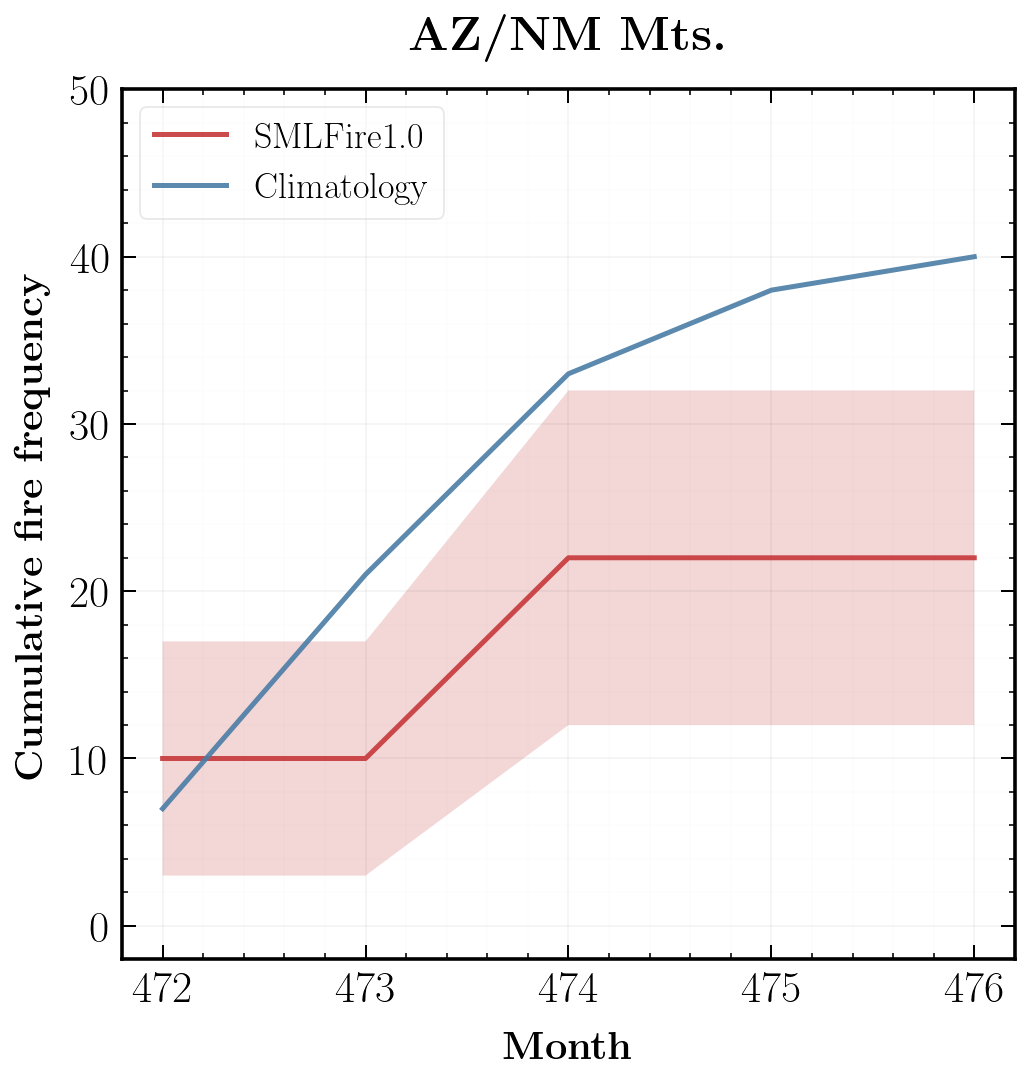

In [9]:
rindx= 11
plt_reg= 'pnwmts'
plot_yr= 2022
fig, ax= plt.subplots(figsize= (8, 8))

pred_ml_fire_freq= np.cumsum(X_pred_ur_df.groupby('reg_indx').get_group(rindx).groupby('month')['pred_fire_freq'].sum())
plt.plot(X_pred_ur_df.groupby('reg_indx').get_group(rindx).month.unique(), pred_ml_fire_freq, label= 'SMLFire1.0', linewidth= 2.5)
plt.fill_between(X_pred_ur_df.groupby('reg_indx').get_group(rindx).month.unique(), pred_ml_fire_freq - np.ceil(2*np.sqrt(pred_ml_fire_freq)), \
                                                                                            pred_ml_fire_freq + np.ceil(2*np.sqrt(pred_ml_fire_freq)), linewidth= 2.5, alpha= 0.2)
plt.plot(X_pred_ur_df.groupby('reg_indx').get_group(rindx).month.unique(), np.cumsum(obs_fire_freq_climatology(fire_freq_df= clim_df, pred_mons= [5, 6, 7, 8, 9], regindx= rindx)), \
                                                                                                                label= 'Climatology', linewidth= 2.5)
#plt.plot(X_pred_ur_df.groupby('reg_indx').get_group(rindx).month.unique(), np.cumsum(X_pred_ur_df.groupby('reg_indx').get_group(rindx).groupby('month')['fire_freq'].sum()), \
#                                                                                                                label= 'Observations', linestyle='--', color='black', linewidth= 3)

ax.set_ylabel(r'{\bf Cumulative fire frequency}', fontsize= 20, labelpad= 10);
ax.set_xlabel(r'{\bf Month}', fontsize= 20, labelpad= 10);
ax.set_ylim(-2, 50)

ax.set_title(r'{\bf %s}'%reg_name[rindx], fontsize= 24, pad= 20);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.legend(loc= 'upper left', frameon= True, fontsize= 18);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/smlfire_output/dynamical_forecasts/pred_fire_freq_%s'%freq_id + '_%d'%seed + '_%d_'%plot_yr + 'df_%d'%ens_no + '_%s.png'%plt_reg, bbox_inches='tight', dpi= 200);

### Spatial frequency map

In [35]:
pred_freq_xarr= xarray.DataArray(data= X_pred_ur_df['pred_fire_freq'].to_numpy().reshape(len(pred_mon_arr), 208, 155),
        dims=["month", "Y", "X"],
        coords=dict(
            X=(["X"], np.linspace(-2349250, -501250, 155)),
            Y=(["Y"], np.linspace(3166500, 682500, 208)),
            time= (["month"], pred_mon_arr),),)
#pred_freq_xarr.to_netcdf('../sav_files/ssf_pred_files/pred_freq_xarr_rs_%s'%freq_id + '_%d_'%seed + 'obs_%s.nc'%target_yr)

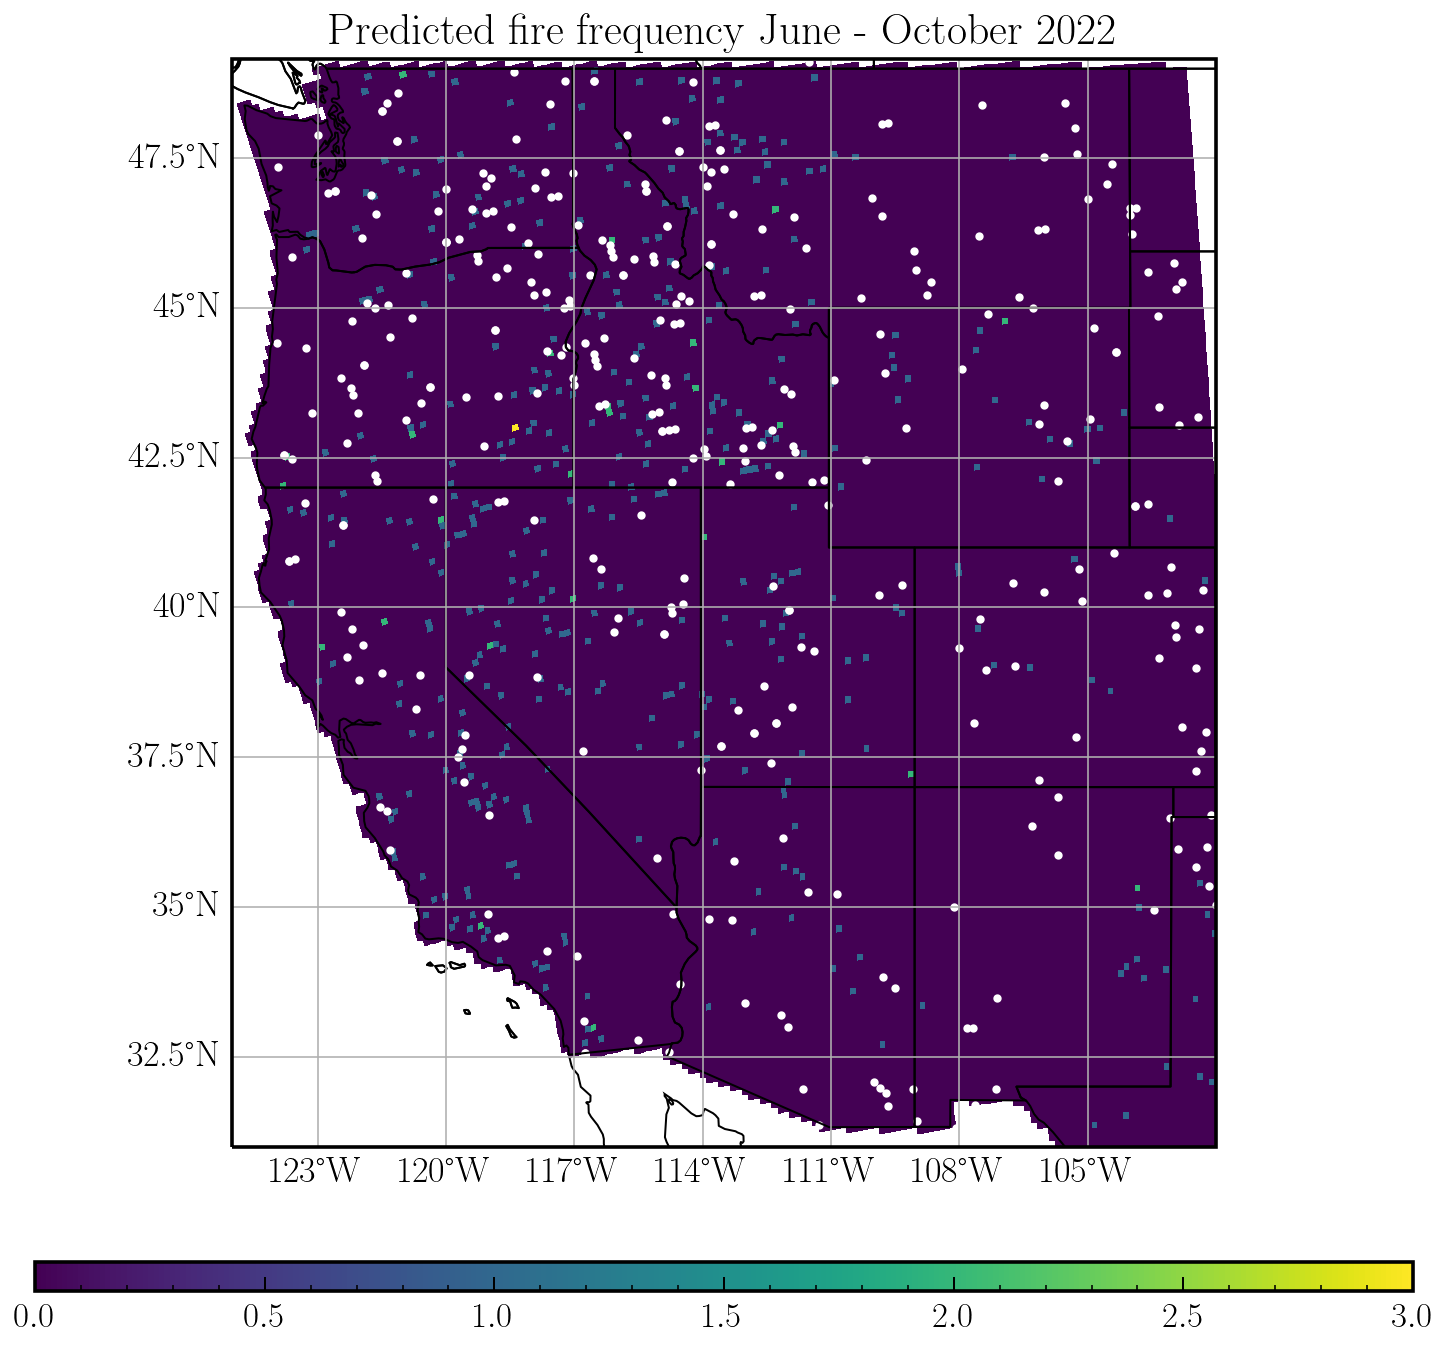

In [36]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
lat_long_fire_grid= coord_transform(pred_freq_xarr['X'][:].data, pred_freq_xarr['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')
wildfire_plot_yr= wildfire_df[(wildfire_df.final_year== target_yr)&(wildfire_df.final_month >= 6)&(wildfire_df.final_month <= 10)]

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');

CS= ax.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_freq_xarr.sum(axis= 0, skipna= False), cmap=plt.cm.viridis) 
cax= fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.1, ax.get_position().width, 0.02])
cbar= fig.colorbar(CS, cax= cax, orientation= 'horizontal', shrink= 0.7)
ax.scatter(wildfire_plot_yr['final_lon'], wildfire_plot_yr['final_lat'], c= 'white', s= 10, transform=ccrs.PlateCarree())

gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1) 
ax.set_title(r'Predicted fire frequency June - October %s'%target_yr, fontsize= 22);
#plt.savefig('../plots/smlfire_output/pred_fire_freq_%s'%freq_id + '_%d'%seed + '_%d_'%plot_yr + 'obs_wus.png', bbox_inches='tight', dpi= 200);

## Fire probability map

In [10]:
# Function to generate a spatial map of fire probability forecasts from a saved MDN model and save the resultant xarray for post-processing
fire_prob_pred_func(freq_id= '08_07_23', seed= 654, X_tot_df= X_pred_ur_df, X_test_df= X_pred_test_df, pred_mon_arr= pred_mon_arr, sav_flag= True, target_year= target_yr, \
                                                                                                                            firemon_pred_flag= 'dynamical_forecasts', ens_no= ens_no)

747/747 [==============================] - 0s 366us/step
Saved fire probability xarray for 2023


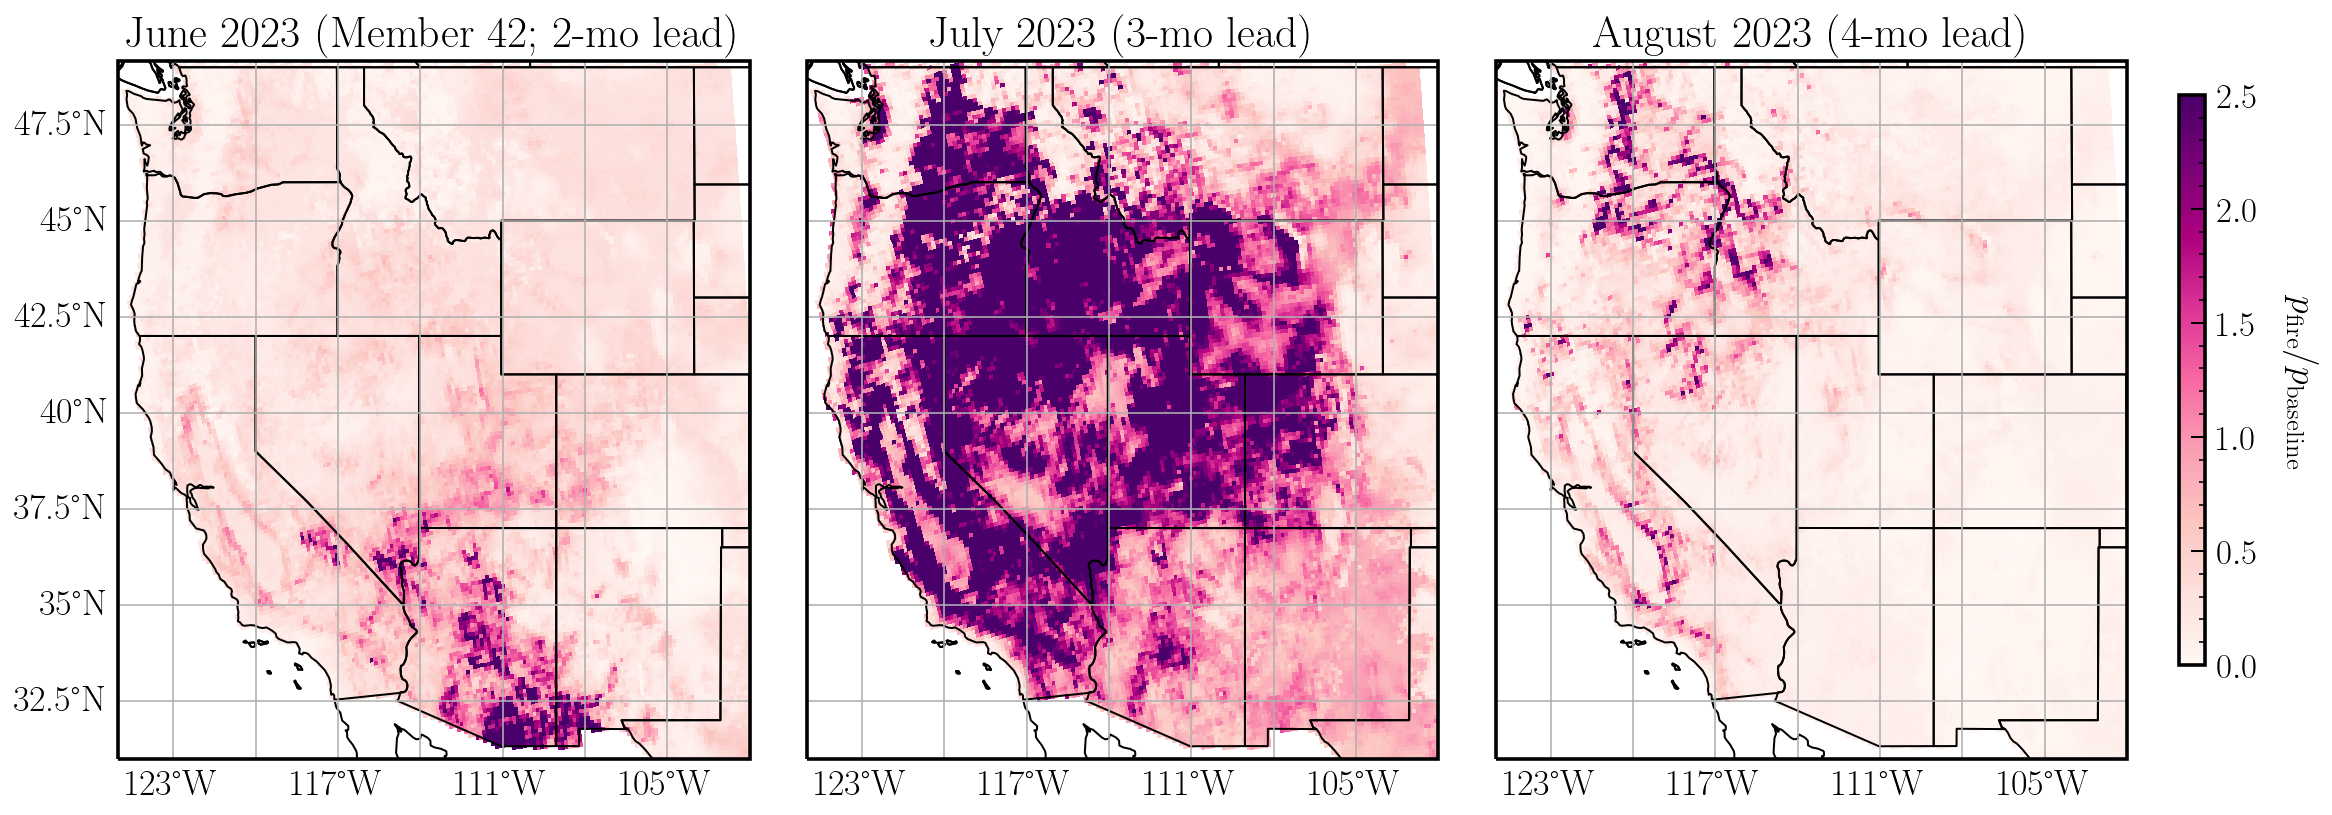

In [12]:
plot_yr= 2023
lead_mo_may= 1
pred_prob_xarr_jun_2020= mon_fire_prob_pred(freq_id= '08_07_23', seed= 654, plot_yr= plot_yr, fmon= 5, fire_df= wildfire_df, firemon_pred_flag= 'dynamical_forecasts', ens_no= ens_no, pred_fire_df= mdn_freq_test_df)
pred_prob_xarr_jul_2020= mon_fire_prob_pred(freq_id= '08_07_23', seed= 654, plot_yr= plot_yr, fmon= 6, fire_df= wildfire_df, firemon_pred_flag= 'dynamical_forecasts', ens_no= ens_no, pred_fire_df= mdn_freq_test_df)
pred_prob_xarr_aug_2020= mon_fire_prob_pred(freq_id= '08_07_23', seed= 654, plot_yr= plot_yr, fmon= 7, fire_df= wildfire_df, firemon_pred_flag= 'dynamical_forecasts', ens_no= ens_no, pred_fire_df= mdn_freq_test_df)
lat_long_fire_grid= coord_transform(pred_prob_xarr_jun_2020['X'][:].data, pred_prob_xarr_jun_2020['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')

extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(4, 6)

ax= fig.add_subplot(gs[0:4, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');
CS= ax.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_prob_xarr_jun_2020, vmin= 0, vmax= 2.5, cmap=plt.cm.RdPu)
if target_yr != 2023:
    ax.scatter(wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 +5]['final_lon'], wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 + 5]['final_lat'], c= 'black', s= 20, transform=ccrs.PlateCarree())
#cax= fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.1, ax.get_position().width, 0.02])
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1)

ax1= fig.add_subplot(gs[0:4, 2:4], projection=ccrs.PlateCarree())
ax1.set_extent(extent);
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black');
CS1= ax1.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_prob_xarr_jul_2020, vmin= 0, vmax= 2.5, cmap=plt.cm.RdPu)
if target_yr != 2023:
    ax1.scatter(wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 +6]['final_lon'], wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 +6]['final_lat'], c= 'black', s= 20, transform=ccrs.PlateCarree())
gl1= ax1.gridlines(draw_labels=True);
gl1.xlabel_style = {'size': 18, 'color': 'black'}
gl1.ylabel_style = {'size': 18, 'color': 'black'}
gl1.top_labels = False
gl1.left_labels = False
gl1.right_labels = False
ax1.set_aspect(1.4/1)

ax2= fig.add_subplot(gs[0:4, 4:6], projection=ccrs.PlateCarree())
ax2.set_extent(extent);
ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax2.add_feature(cfeature.STATES, edgecolor='black');
CS2= ax2.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_prob_xarr_aug_2020, vmin= 0, vmax= 2.5, cmap=plt.cm.RdPu)
if target_yr != 2023:
    ax2.scatter(wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 + 7]['final_lon'], wildfire_df[wildfire_df['fire_month'] == (plot_yr - 1984)*12 +7]['final_lat'], c= 'black', s= 20, transform=ccrs.PlateCarree())
cax= fig.add_axes([ax2.get_position().x1 + 0.02, ax2.get_position().y1 - 0.35, 0.01, ax2.get_position().height + 0.05])
cbar= fig.colorbar(CS2, cax= cax, orientation= 'vertical')
cbar.set_label(r'$p_{\rm fire}/p_{\rm baseline}$', labelpad= 30, rotation= 270, fontsize= 18)
gl2= ax2.gridlines(draw_labels=True);
gl2.xlabel_style = {'size': 18, 'color': 'black'}
gl2.ylabel_style = {'size': 18, 'color': 'black'}
gl2.top_labels = False
gl2.left_labels = False
gl2.right_labels = False
ax2.set_aspect(1.4/1)
if firemon_pred_flag == 'observations':
    ax.set_title(r'June %d'%plot_yr, fontsize= 22);
    ax1.set_title(r'July %d'%plot_yr, fontsize= 22);
    ax2.set_title(r'August %d'%plot_yr, fontsize= 22);
    # plt.savefig('../plots/smlfire_output/pred_fire_prob_%s'%freq_id + '_%d_'%seed + 'obs_%d.png'%plot_yr, bbox_inches='tight', dpi= 200);
else:
    ax.set_title(r'June %d'%plot_yr + ' (Member %d'%ens_no + '; %d-mo lead)'%(lead_mo_may+1) + '', fontsize= 22);
    ax1.set_title(r'July %d'%plot_yr + ' (%d-mo lead)'%(lead_mo_may+2) + '', fontsize= 22);
    ax2.set_title(r'August %d'%plot_yr + ' (%d-mo lead)'%(lead_mo_may+3) + '', fontsize= 22);
    # plt.savefig('../plots/smlfire_output/' + '%s'%firemon_pred_flag + '/pred_fire_prob_%s'%freq_id + '_%d_'%seed + '%d'%ens_no + '_%d.png'%plot_yr, bbox_inches='tight', dpi= 200);

### Baseline and climate predictor comparison

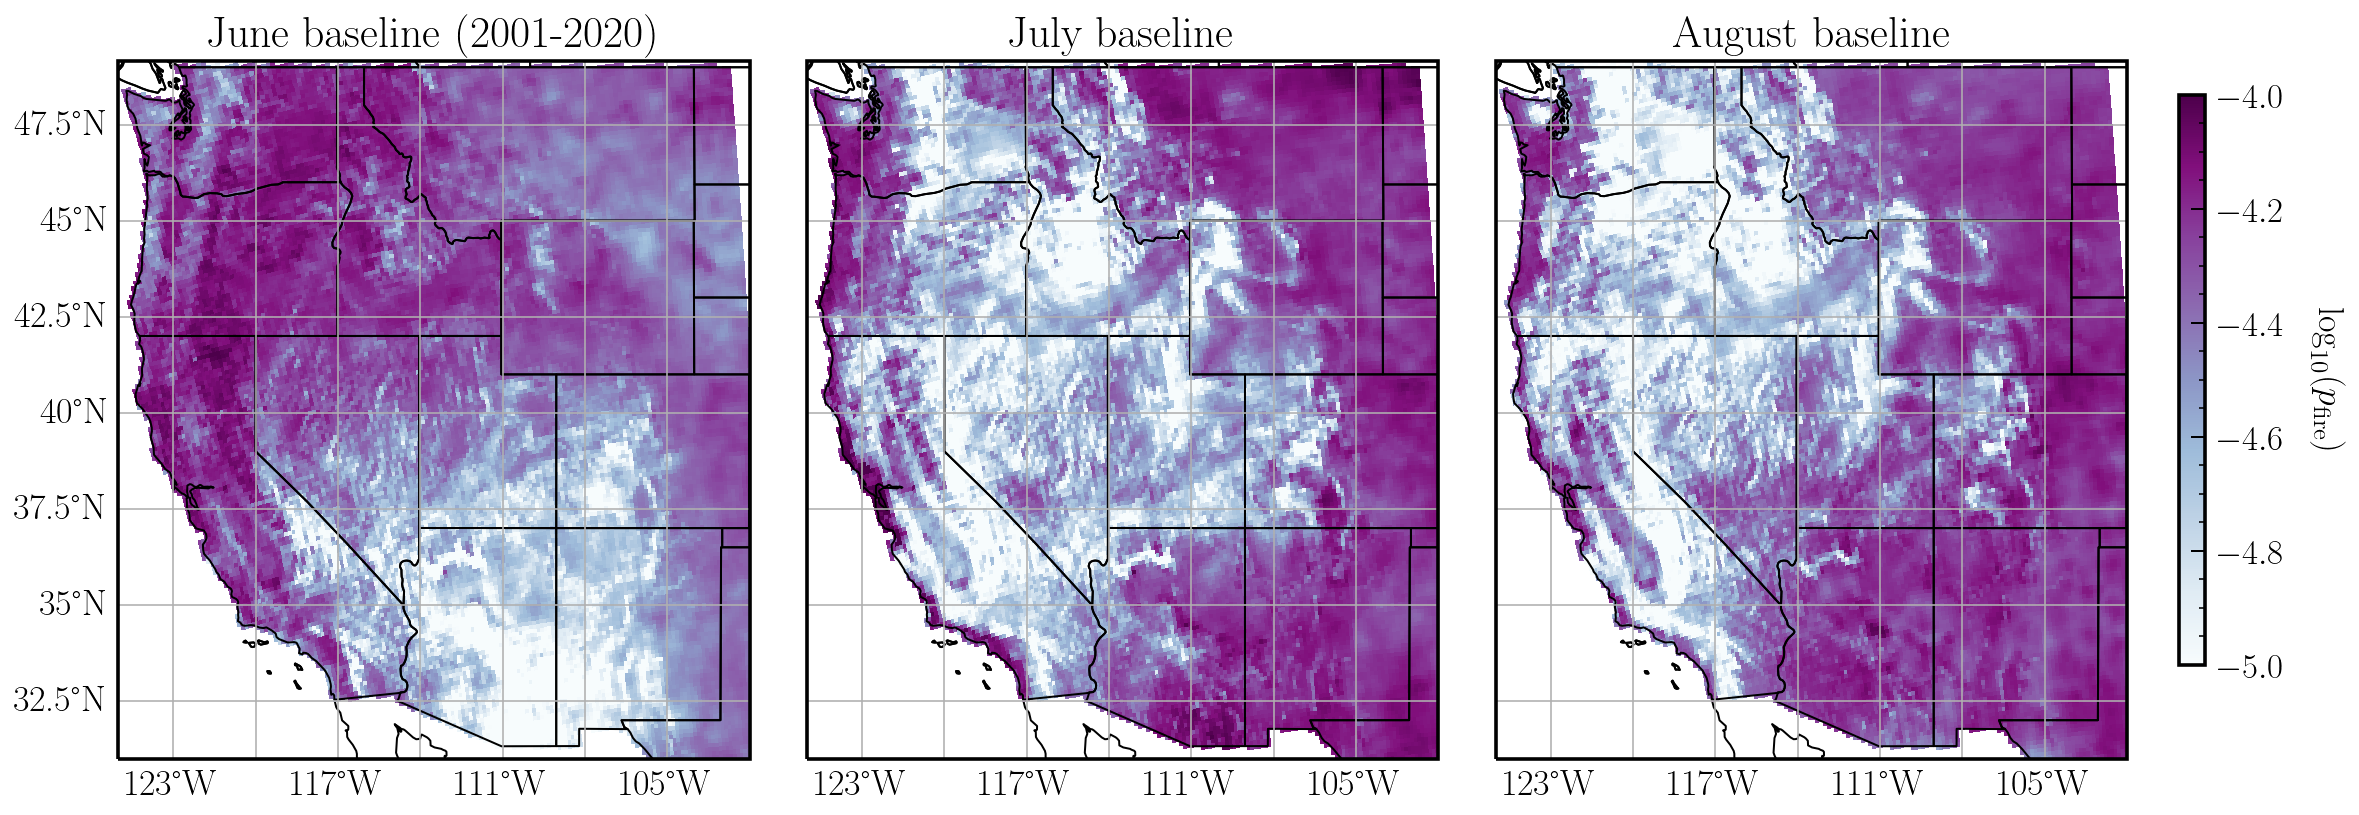

In [ ]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(4, 6)

ax= fig.add_subplot(gs[0:4, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');
CS= ax.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], np.log10(pred_prob_xarr_jun_baseline/np.sum(pred_prob_xarr_jun_baseline)), vmin= -5, vmax= -4, cmap=plt.cm.BuPu) #.mean(axis= 0, skipna= False)  np.log10(pred_prob_xarr[0, : , :])
#cax= fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.1, ax.get_position().width, 0.02])
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1)
ax.set_title(r'June baseline (2001-2020)', fontsize= 22);

ax1= fig.add_subplot(gs[0:4, 2:4], projection=ccrs.PlateCarree())
ax1.set_extent(extent);
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black');
CS1= ax1.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1],np.log10(pred_prob_xarr_jul_baseline/np.sum(pred_prob_xarr_jul_baseline)), vmin= -5, vmax= -4, cmap=plt.cm.BuPu) #.mean(axis= 0, skipna= False)
gl1= ax1.gridlines(draw_labels=True);
gl1.xlabel_style = {'size': 18, 'color': 'black'}
gl1.ylabel_style = {'size': 18, 'color': 'black'}
gl1.top_labels = False
gl1.left_labels = False
gl1.right_labels = False
ax1.set_aspect(1.4/1)
ax1.set_title(r'July baseline', fontsize= 22);

ax2= fig.add_subplot(gs[0:4, 4:6], projection=ccrs.PlateCarree())
ax2.set_extent(extent);
ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax2.add_feature(cfeature.STATES, edgecolor='black');
CS2= ax2.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], np.log10(pred_prob_xarr_aug_baseline/np.sum(pred_prob_xarr_aug_baseline)), vmin= -5, vmax= -4, cmap=plt.cm.BuPu) #.mean(axis= 0, skipna= False)
cax= fig.add_axes([ax2.get_position().x1 + 0.02, ax2.get_position().y1 - 0.35, 0.01, ax2.get_position().height + 0.05])
cbar= fig.colorbar(CS2, cax= cax, orientation= 'vertical')
cbar.set_label(r'${\rm log}_{10}(p_{\rm fire})$ ', labelpad= 30, rotation= 270, fontsize= 18)
gl2= ax2.gridlines(draw_labels=True);
gl2.xlabel_style = {'size': 18, 'color': 'black'}
gl2.ylabel_style = {'size': 18, 'color': 'black'}
gl2.top_labels = False
gl2.left_labels = False
gl2.right_labels = False
ax2.set_aspect(1.4/1)
ax2.set_title(r'August baseline', fontsize= 22);
#plt.savefig('../plots/smlfire_output/pred_fire_prob_rs_obs_baseline.png', bbox_inches='tight', dpi= 200);

In [ ]:
vpd_xarr= xarray.open_dataarray('../data/12km/climate/primary/vpd.nc').sel(time= slice('1984-01-15', '2023-05-15'))
tmax_xarr= xarray.open_dataarray('../data/12km/climate/primary/tmax.nc').sel(time= slice('1984-01-15', '2023-05-15'))
prec_xarr= xarray.open_dataarray('../data/12km/climate/primary/prec.nc').sel(time= slice('1984-01-15', '2023-05-15'))
ffwi_xarr= xarray.open_dataarray('../data/12km/climate/primary/ffwi.nc').sel(time= slice('1984-01-15', '2023-05-15'))

# antprec_xarr= xarray.DataArray(data= X_pred_ur_df['Avgprec_3mo'].to_numpy().reshape(3, 208, 155),
#         dims=["month", "Y", "X"],
#         coords=dict(
#             X=(["X"], np.linspace(-2349250, -501250, 155)),
#             Y=(["Y"], np.linspace(3166500, 682500, 208)),
#             time= (["month"], np.linspace(0, 2, 3, dtype= np.int64)),),)
lat_long_grid= coord_transform(ffwi_xarr['X'][:].data, ffwi_xarr['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')

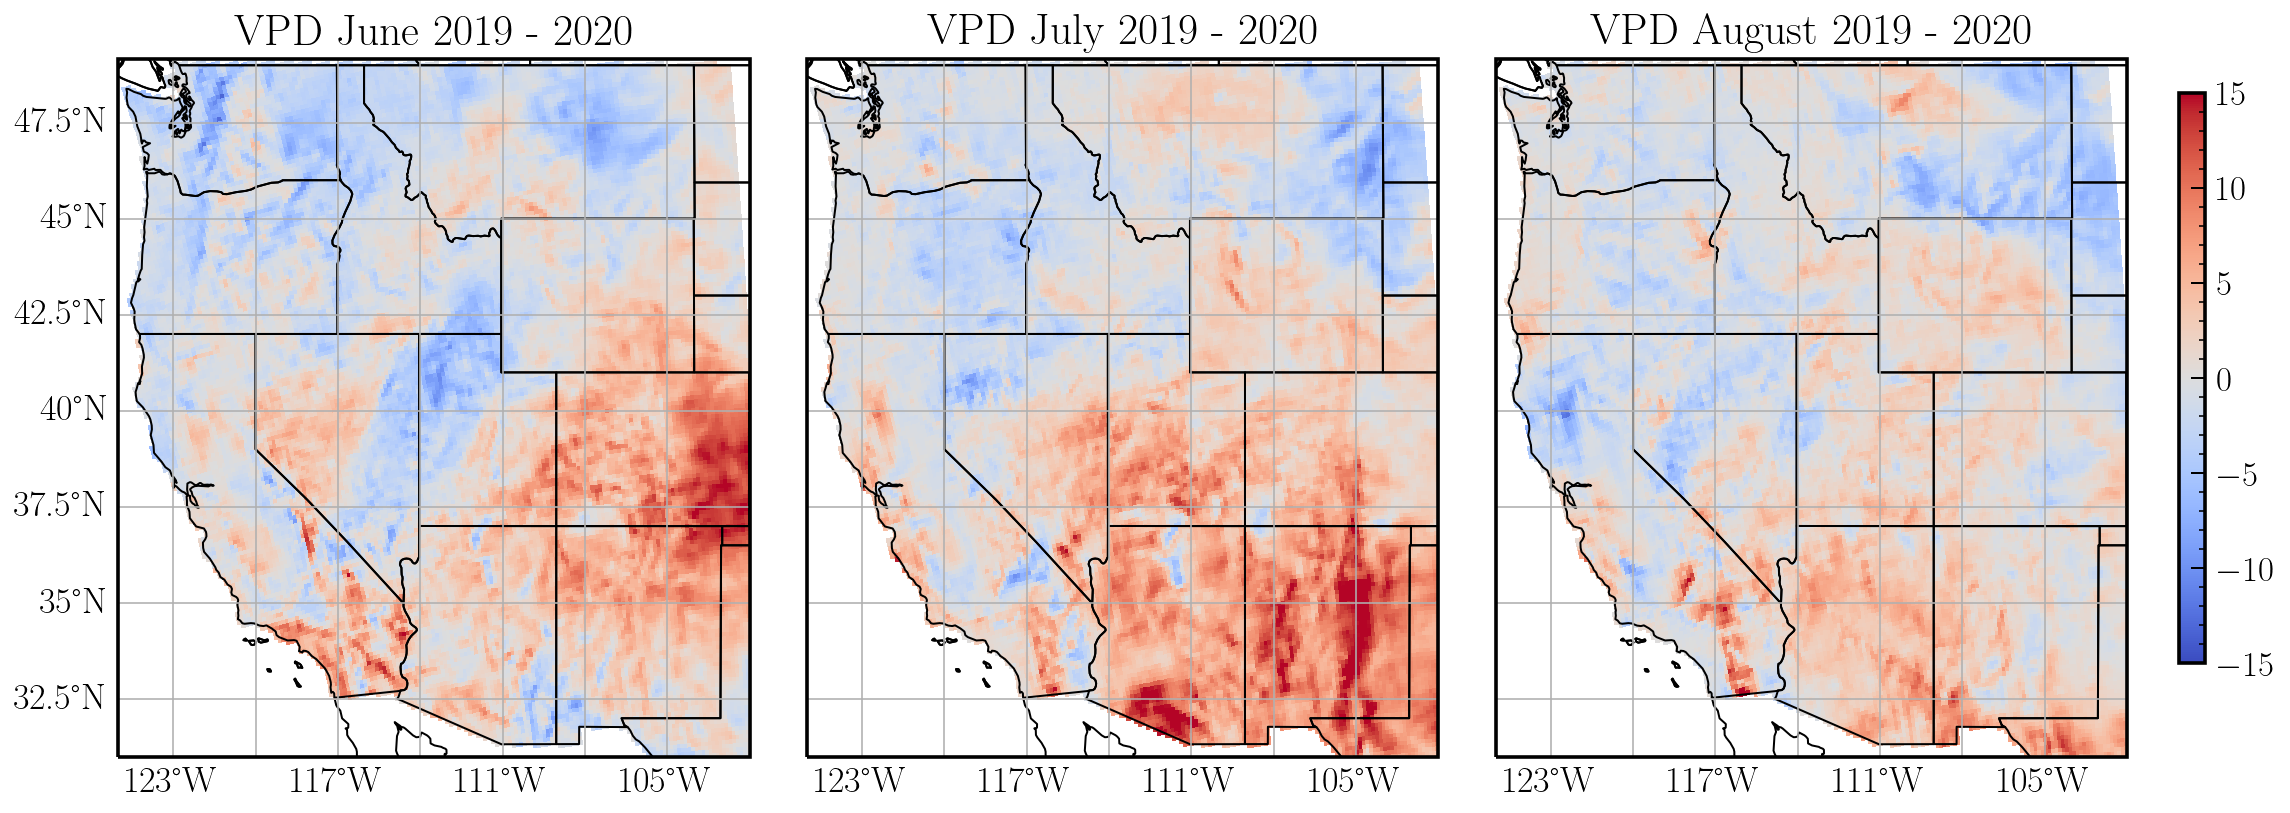

In [ ]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(4, 6)

ax= fig.add_subplot(gs[0:4, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');
CS= ax.pcolormesh(lat_long_grid[0], lat_long_fire_grid[1], ffwi_xarr.sel(time='2019-06-15') - ffwi_xarr.sel(time='2020-06-15').values, vmin= -15, vmax= 15, cmap=plt.cm.coolwarm) #.mean(axis= 0, skipna= False)  np.log10(pred_prob_xarr[0, : , :])
#cax= fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.1, ax.get_position().width, 0.02])
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1)
ax.set_title(r'VPD June 2019 - 2020', fontsize= 22);

ax1= fig.add_subplot(gs[0:4, 2:4], projection=ccrs.PlateCarree())
ax1.set_extent(extent);
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black');
CS1= ax1.pcolormesh(lat_long_grid[0], lat_long_fire_grid[1], ffwi_xarr.sel(time='2019-07-15') - ffwi_xarr.sel(time='2020-07-15').values, vmin= -15, vmax= 15, cmap=plt.cm.coolwarm) #.mean(axis= 0, skipna= False)
gl1= ax1.gridlines(draw_labels=True);
gl1.xlabel_style = {'size': 18, 'color': 'black'}
gl1.ylabel_style = {'size': 18, 'color': 'black'}
gl1.top_labels = False
gl1.left_labels = False
gl1.right_labels = False
ax1.set_aspect(1.4/1)
ax1.set_title(r'VPD July 2019 - 2020', fontsize= 22);

ax2= fig.add_subplot(gs[0:4, 4:6], projection=ccrs.PlateCarree())
ax2.set_extent(extent);
ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax2.add_feature(cfeature.STATES, edgecolor='black');
CS2= ax2.pcolormesh(lat_long_grid[0], lat_long_fire_grid[1], ffwi_xarr.sel(time='2019-08-15') - ffwi_xarr.sel(time='2020-08-15').values, vmin= -15, vmax= 15, cmap=plt.cm.coolwarm) #.mean(axis= 0, skipna= False)
cax= fig.add_axes([ax2.get_position().x1 + 0.02, ax2.get_position().y1 - 0.35, 0.01, ax2.get_position().height + 0.05])
cbar= fig.colorbar(CS2, cax= cax, orientation= 'vertical')
#cbar.set_label(r'Log fire probability', labelpad= 20, rotation= 270, fontsize= 18)
gl2= ax2.gridlines(draw_labels=True);
gl2.xlabel_style = {'size': 18, 'color': 'black'}
gl2.ylabel_style = {'size': 18, 'color': 'black'}
gl2.top_labels = False
gl2.left_labels = False
gl2.right_labels = False
ax2.set_aspect(1.4/1)
ax2.set_title(r'VPD August 2019 - 2020', fontsize= 22);
#plt.savefig('../plots/smlfire_output/pred_fire_prob_2022_obs.png', bbox_inches='tight', dpi= 200);

## Fire size trends

In [13]:
sav_freq_flag= False
if sav_freq_flag:
    target_yr= 2022
    firemon_pred_flag= 'dynamical_forecasts'
    ens_no= 35
    freq_id= '08_07_23'
    seed= 654

    pred_mon_arr=  np.array([461, 462, 463]) - (2022 - target_yr)*12

    if firemon_pred_flag == 'observations':
        mdn_freq_test_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%target_yr + '_%s.h5'%firemon_pred_flag)
        freq_loc_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/freq_loc_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%target_yr + '_%s.h5'%firemon_pred_flag)
        X_pred_ur_df= pd.read_hdf('../sav_files/ssf_pred_files/%s_dataframe'%freqlabel + '_%s'%freq_id + '_%d'%seed +  '_obs_%d.h5'%target_yr)
    else:
        mdn_freq_test_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/' + '%s'%firemon_pred_flag + '/mdn_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%ens_no + '_%d.h5'%target_yr)
        freq_loc_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/' + '%s'%firemon_pred_flag + '/freq_loc_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%ens_no + '_%d.h5'%target_yr)
        X_pred_ur_df= pd.read_hdf('../sav_files/ssf_pred_files/' + '%s'%firemon_pred_flag + '/pred_fire_freq_dataframe_%s'%freq_id + '_%d'%seed +  '_df_%d'%ens_no + '_%d.h5'%target_yr)

In [17]:
nregions= 18
X_sizes_train, X_sizes_val, y_sizes_train, y_sizes_val, fire_size_train, fire_size_test, X_sizes_test, y_sizes_test= fire_size_data(res= '12km', \
                            dropcols= drop_col_func(mod_type= 'normal', add_var_flag= True, add_var_list= ['SWE_max', 'SWE_mean', 'AvgSWE_3mo', 'Delta_T']), \
                            start_month= 444, tot_test_months= 24, threshold= 4, scaled= True, tflag= True, final_year= 2022) #tflag= True; scaled= True, rh_flag= True
X_sizes_train_df= pd.concat([X_sizes_train, X_sizes_val], sort= False).reset_index().drop(columns=['index'])
X_sizes_tot= pd.concat([X_sizes_train_df, X_sizes_test], sort= False).reset_index().drop(columns=['index'])
fire_size_tot= pd.concat([fire_size_train, fire_size_test], sort= False).reset_index().drop(columns=['index'])

max_fire_train_arr= []
sum_fire_train_arr= []
for r in tqdm(range(nregions)):
    max_fire_train_arr.append(np.max(np.concatenate([fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').get_group(k).fire_size.to_numpy()/1e6 \
                                    for k in fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').groups.keys()])))
    #sum_fire_train_arr.append(np.max([np.sum(fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').get_group(k).fire_size.to_numpy()/1e6) \
    #                                for k in fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').groups.keys()]))
    
max_fire_train_arr= np.asarray(max_fire_train_arr)
sum_fire_train_arr= max_fire_size_sum_func(fire_size_df= fire_size_tot, final_month= 480) #update final month for 2023!

100%|██████████| 18/18 [00:01<00:00, 13.60it/s]


In [18]:
size_id= '08_21_23'
mdn_gpd_mod= tf.keras.models.load_model('../sav_files/fire_size_mods/mdn_gpd_size_model_%s'%size_id, custom_objects= {'gpd_loss': gpd_loss, 'gpd_accuracy': gpd_accuracy})
mdn_gpd_ext_mod= tf.keras.models.load_model('../sav_files/fire_size_mods/mdn_gpd_ext_size_model_%s'%size_id, custom_objects= {'gpd_loss': gpd_loss, 'gpd_accuracy': gpd_accuracy})
X_sizes_test_df= X_pred_ur_df.drop(columns= ['Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'RH_min3', 'FFWI_max7', 'Avgprec_4mo',  'Avgprec_2mo', 'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', \
                                                                                            'VPD_max7', 'Tmin_max7', 'Elev', 'Delta_T', 'CAPE', 'Southness', 'X', 'Y', 'fire_freq', 'pred_fire_prob'])

In [19]:
sizelabel= 'gpd'
if sizelabel == 'gpd_ext':
    reg_gpd_ml_pred_size_df= grid_ssf_size_func(mdn_model= mdn_gpd_ext_mod, stat_model= gpd_model, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, pred_mon_flag= True, pred_mons= pred_mon_arr, \
                                        nsamps= 1000, loc_df= freq_loc_df, ml_freq_df= mdn_freq_test_df, X_test_dat= X_sizes_test_df)
elif sizelabel == 'gpd':
    reg_gpd_ml_pred_size_df= grid_ssf_size_func(mdn_model= mdn_gpd_mod, stat_model= gpd_model, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, pred_mon_flag= True, pred_mons= pred_mon_arr, \
                                        nsamps= 1000, loc_df= freq_loc_df, ml_freq_df= mdn_freq_test_df, X_test_dat= X_sizes_test_df)
if firemon_pred_flag == 'observations':
    reg_gpd_ml_pred_size_df.to_hdf('../sav_files/fire_size_pred_dfs/pred_size_df_ml_gpd_%s'%size_id + '_%s'%('_'.join(freqlabel.split('_')[1:])) \
                                                                                                    + '_%s'%sizelabel + '_%s.h5'%target_yr, key= 'df', mode= 'w')
else:
    reg_gpd_ml_pred_size_df.to_hdf('../sav_files/fire_size_pred_dfs/' + '%s'%firemon_pred_flag + '/pred_size_df_ml_gpd_%s'%size_id + '_%s'%('_'.join(freqlabel.split('_')[1:])) \
                                                                                                            + '_%s'%sizelabel + '_%d'%ens_no + '_%s.h5'%target_yr, key= 'df', mode= 'w')

  0%|          | 0/18 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 1/18 [00:00<00:02,  7.31it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 4/18 [00:00<00:00, 14.56it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 9/18 [00:00<00:00, 25.42it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 12/18 [00:00<00:00, 19.55it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 15/18 [00:00<00:00, 16.06it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 17/18 [00:01<00:00, 14.12it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 18/18 [00:01<00:00, 14.59it/s]


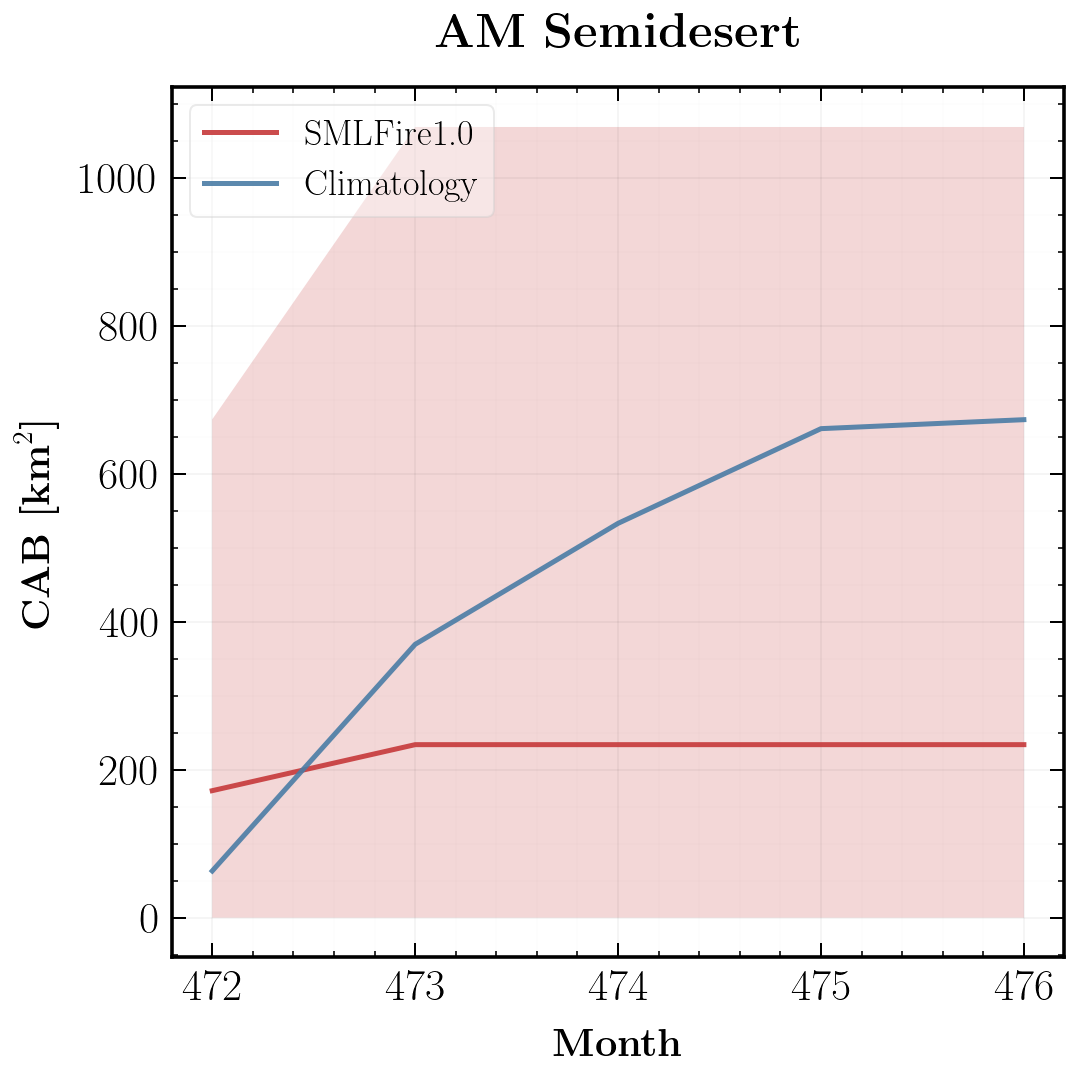

In [26]:
rindx= 10
plt_reg= 'aznmmts'
plot_yr= 2022
fig, ax= plt.subplots(1, 1, figsize=(8, 8))

ax.plot(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx)['month'], np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx)['mean_size']), \
                                                                                                                   linewidth= 2.5, label= 'SMLFire1.0')
ax.fill_between(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx)['month'], np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx)['high_1sig_size']), \
                                                                               np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx)['low_1sig_size']), alpha=0.2)
ax.plot(pred_mon_arr, np.cumsum(obs_burned_area_climatology(fire_size_df= fire_size_tot, pred_mons= [5, 6, 7, 8, 9],\
                                                                                                                    regindx= rindx)), linewidth= 2.5, label= 'Climatology')
#ax.plot(pred_mon_arr, np.cumsum(obs_burned_area_ts(fire_size_df= fire_size_tot, pred_mons= pred_mon_arr, regindx= rindx)), \
#                                                                                                                    linestyle= '--', color= 'black', linewidth= 3, label= 'Observations')

ax.set_ylabel(r'{\bf CAB [${\bf km}^2$]}', fontsize= 20, labelpad= 10);
ax.set_xlabel(r'{\bf Month}', fontsize= 20, labelpad= 10);
#ax.set_ylim(-100, 3000)

ax.set_title(r'{\bf %s}'%reg_name[rindx], fontsize= 24, pad= 20);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.legend(loc= 'upper left', frameon= True, fontsize= 18);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/smlfire_output/dynamical_forecasts/pred_fire_size_%s'%size_id + '_%d_'%plot_yr + 'obs_%s.png'%plt_reg, bbox_inches='tight', dpi= 200);

In [4]:
# size_id= '08_21_23'
# target_yr= 2022
# pred_mon_arr= np.array([461, 462, 463, 464, 465])
# reg_gpd_ml_pred_size_df= pd.read_hdf('../sav_files/ssf_pred_files/pred_size_df_ml_gpd_%s'%size_id + '_mean_freq_%s.h5'%target_yr)
# reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW Mts.", 6: "Columbia Plateau", 7:"Northern Rockies", \
#           8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
#           15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}
# pred_mon_arr= np.insert(pred_mon_arr, 0, [457, 458, 459, 460])

## Correlation between antecedent and fire month predictors

In [ ]:
# load in data frame with observed climate, vegetation, and human predictors

clim_df= pd.read_hdf('../data/clim_fire_freq_12km_w2022_data.h5') 
clim_df.loc[clim_df[clim_df.fire_freq > 1].index, 'fire_freq']= np.ones(len(clim_df[clim_df.fire_freq > 1].index), dtype= np.int64)

In [ ]:
jun_arr= np.arange(5, 465, 12)
may_arr= jun_arr - 1
jul_arr= jun_arr + 1
aug_arr= jun_arr + 2
summer_arr= np.sort(np.append(np.append(np.append(jun_arr, jul_arr), aug_arr), may_arr))

In [ ]:
ant_prec_corr_arr= []
ant_vpd_corr_arr= []
clim_df_groups= clim_df[clim_df.month.isin(summer_arr)].groupby(['X', 'Y'])
clim_df_keys= clim_df.dropna().groupby(['X', 'Y']).groups.keys()
for k in tqdm(clim_df_keys):
    ant_prec_corr_arr.append(stats.pearsonr(clim_df_groups.get_group(k)['Prec'], clim_df_groups.get_group(k)['Avgprec_3mo'])[0])
    ant_vpd_corr_arr.append(stats.pearsonr(clim_df_groups.get_group(k)['VPD'], clim_df_groups.get_group(k)['AvgVPD_3mo'])[0])

100%|██████████| 23903/23903 [00:25<00:00, 922.08it/s]


In [ ]:
np.mean(ant_prec_corr_arr), np.mean(ant_vpd_corr_arr)

(0.12658250133508814, 0.5732348407759681)

In [ ]:
clim_fire_df= pd.read_hdf('../data/clim_fire_size_12km_w2022_data.h5') 

In [ ]:
clim_fire_df_groups= clim_fire_df.drop_duplicates(subset= 'fire_indx').groupby(['grid_x', 'grid_y'])
clim_fire_df_keys= list(clim_fire_df.drop_duplicates(subset= 'fire_indx').groupby(['grid_x', 'grid_y']).groups.keys())
prec_df= pd.Series({})
ant_prec_df= pd.Series({})
vpd_df= pd.Series({})
ant_vpd_df= pd.Series({})

for k in tqdm(clim_fire_df_keys):
    prec_df= pd.concat([prec_df, clim_fire_df_groups.get_group(k)['Prec']])
    ant_prec_df= pd.concat([ant_prec_df, clim_fire_df_groups.get_group(k)['Avgprec_3mo']])
    vpd_df= pd.concat([vpd_df, clim_fire_df_groups.get_group(k)['VPD']])
    ant_vpd_df= pd.concat([ant_vpd_df, clim_fire_df_groups.get_group(k)['AvgVPD_3mo']])
ant_fire_prec_corr_arr= stats.pearsonr(prec_df.values, ant_prec_df.values)[0]
ant_fire_vpd_corr_arr= stats.pearsonr(vpd_df.values, ant_vpd_df.values)[0]

100%|██████████| 9648/9648 [00:04<00:00, 2134.90it/s]


In [ ]:
ant_fire_prec_corr_arr, ant_fire_vpd_corr_arr

(0.09408614764088513, 0.5373033958640666)